In [3]:
library(ppcor)
library(qgraph)
library(GGMselect)
library(gplots)
library(colorspace)
library(network)
library(reshape)
library(ggplot2)
library(GeneNet)
library(readxl)

# load data

In [1]:
classes = unique(gsub('_edge_list.csv','',list.files('data-raw/',pattern = '*edge_list.csv')))
classes

[1] "k_2010_group_1" "k_2010_group_2" "k_2010_group_4" "k_2013_group_1"
 [5] "k_2013_group_2" "k_2013_group_4" "split_group_1"  "split_group_2" 
 [9] "split_group_4"  "vis_group_1"    "vis_group_2"    "vis_group_4"

In [987]:
nets = lapply(classes,function(x){
    print(x)
    igg_i = str_sub(x,str_length(x),str_length(x))
    
    ### load residual data
    df <- as.data.frame(read_excel(path="Benedetti_NatCommun/SupplementalMaterial_DatasetS1_PreprocessedData.xls",
                               sheet=paste0(gsub('_g.*','',x),"_residuals"),col_names=T))
    data <- df[,2:dim(df)[2]]
    rownames(data) <- df[,1]
    data=data[,grepl(paste0('IgG',igg_i),colnames(data))]
    colnames(data)=gsub('.*_','',colnames(data))
    
    l=list(edge_list = read.csv(paste0('data-raw/',x,'_edge_list.csv'),row.names = 1),
         motif_abd_table = read.csv(paste0('data-raw/',x,'_motif_abd_table.csv'),row.names = 1),
         glycan_abd_table = t(data), #t(read.csv(paste0('data-raw/',x,'.csv'),row.names = 1)),
         node_list = read.csv(paste0('data-raw/',x,'_node_list.csv'),row.names = 1),
         substructure_abd_table = read.csv(paste0('data-raw/',x,'_substructure_abd_table.csv'),row.names = 1))
    
    row.names(l$glycan_abd_table) = sapply(row.names(l$glycan_abd_table),function(x)  as.character(N$index[N$if_glycan==x] ))
    l
})
names(nets)=classes

[1] "k_2010_group_1"
[1] "k_2010_group_2"
[1] "k_2010_group_4"
[1] "k_2013_group_1"
[1] "k_2013_group_2"
[1] "k_2013_group_4"
[1] "split_group_1"
[1] "split_group_2"
[1] "split_group_4"
[1] "vis_group_1"
[1] "vis_group_2"
[1] "vis_group_4"


In [988]:
#anyl=i
#pr = nets[[i]]$partial_correlation$estimate

merge_adj_to_edge<-function(adj,anyl,E,igg,save=T){
    m=melt(adj)
    colnames(m) = c('start','end',anyl)
    m$igg = igg
    if(any(grepl('_',m$start))){
        m$start=gsub('_.*','',m$start)
        m$end=gsub('_.*','',m$end)
    }
    write.csv(adj,file=paste0('data-final/',anyl,'.csv'))
    merge(E,m,all=T)
}

# Do edge calculations


In [989]:
#E = nets[[1]]$edge_list
N = nets[[1]]$node_list
head(N)

,index,keep,if_glycan
,<int>,<fct>,<fct>
0,108,yes,G0
1,135,med_root,N
2,139,yes,G1
3,148,yes,G0N
4,154,yes,G0F
5,164,yes,G2


In [990]:
EL_annot = read.csv('data-raw/edge_list.positive_annot.csv')

EL_annot$truth_bokan = ifelse(grepl('FP',EL_annot$Enzyme),'FP',ifelse(grepl('-TP',EL_annot$Enzyme),'TP',NA))
na.omit(EL_annot)


,Enzyme,start,end,truth_bokan
,<fct>,<int>,<int>,<chr>
23,B4GALT-TP,165,184,TP
38,FP,176,195,FP
47,B4GALT-TP,188,196,TP
49,FP,189,199,FP
50,B4GALT-TP,190,197,TP
51,FP,190,200,FP
57,FP,197,201,FP
60,B4GALT-TP,200,201,TP


In [991]:
# use netowrk from bokan
EL_annot = read.csv('data-raw/edge_list.positive_annot.csv')

EL_annot$truth_bokan = ifelse(grepl('FP',EL_annot$Enzyme),'FP',ifelse(grepl('-TP',EL_annot$Enzyme),'TP',NA))
EL_annot$truth_bokan_all = ifelse(EL_annot$Enzyme%in%c('FP',''),'F','T')

if(F){
    E = nets[[1]]$edge_list
}else{
    # load prior knowledge adjacency matrix (inferred pathway in our paper)
    adja <- as.matrix(read.csv("Benedetti_NatCommun/InferredPathway.csv", header = TRUE, sep = ";", dec = ",", row.names = 1))
    adja[is.na(adja)] <- 0
    adja_orig=adja
    adja = melt(adja)
    colnames(adja) = c('start_name','end_name','truth')
    adja$igg = ifelse(gsub('_.*','',adja$start)==gsub('_.*','',adja$end),str_sub(gsub('_.*','',adja$start),4,4),NA)
    adja$start_name = gsub('.*_','',adja$start)
    adja$end_name = gsub('.*_','',adja$end)
    adja = na.omit(adja[adja$start_name!=adja$end_name,])

    adja$start = sapply(adja$start_name,function(x) N$index[N$if_glycan==x])
    adja$end = sapply(adja$end_name,function(x) N$index[N$if_glycan==x])

    E = adja
}



In [992]:


#E$start_name = sapply(E$start,function(x) N$if_glycan[N$index==x])
#E$end_name = sapply(E$end,function(x) N$if_glycan[N$index==x])

#E = merge(E,adja,all.x=T)

Eall = expand.grid(start=unique(E$start),end=unique(E$end))

Eall$start_name = sapply(Eall$start,function(x) N$if_glycan[N$index==x])
Eall$end_name = sapply(Eall$end,function(x) N$if_glycan[N$index==x])
                       
Eall = merge(Eall,adja,all.x=T)
                       
E = droplevels(E[E$truth==1,])
                       
                       
E = merge(E,EL_annot,all.x=T)
Eall = merge(Eall,EL_annot,all.x=T)

head(E)
table(E$truth)
head(Eall)
table(Eall$truth)

start,end,start_name,end_name,truth,igg,Enzyme,truth_bokan,truth_bokan_all
<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<fct>,<chr>,<chr>
108,139,G0,G1,1,2,B4GALT1,NA,T
108,139,G0,G1,1,1,B4GALT1,NA,T
108,148,G0,G0N,1,2,MGAT3,NA,T
108,148,G0,G0N,1,1,MGAT3,NA,T
108,154,G0,G0F,1,2,FUT8,NA,T
108,154,G0,G0F,1,1,FUT8,NA,T



  1 
138 

start,end,start_name,end_name,truth,igg,Enzyme,truth_bokan,truth_bokan_all
<int>,<int>,<fct>,<fct>,<dbl>,<chr>,<fct>,<chr>,<chr>
108,108,G0,G0,NA,NA,NA,NA,NA
108,139,G0,G1,1,2,B4GALT1,NA,T
108,139,G0,G1,1,1,B4GALT1,NA,T
108,148,G0,G0N,1,2,MGAT3,NA,T
108,148,G0,G0N,1,1,MGAT3,NA,T
108,154,G0,G0F,1,2,FUT8,NA,T



  0   1 
712 138 

In [993]:

for(i in 1:length(nets)){ 
    
    N_i = nets[[i]]$node_list
    
    # partial correlation: spearman MOTIF
    X = t(nets[[i]]$motif_abd_table)
    X = X[,keep<-(apply(X,2,sd)>1e-5)]
    #pr =pcor(X,method = 'spearman')
    pr=matrix(tmp<-ggm.estimate.pcor( X , method = 'dynamic'),dimnames = list(rownames(tmp),colnames(tmp)),
              nrow=nrow(tmp),ncol=ncol(tmp)) ### replaced pcor with gmm estimated
    
    #sel = nets[[i]]$node_list$index%in%colnames(X)
    #names = paste(nets[[i]]$node_list$index,nets[[i]]$node_list$if_glycan,sep='_')[sel]
    names = sapply(rownames(pr),function(x) paste(as.character(x),
                                as.character(nets[[i]]$node_list$if_glycan[nets[[i]]$node_list$if_glycan==x]),sep='_'))
    rownames(pr)=colnames(pr)=names
    nets[[i]]$partial_correlation = pr
    
    igg_i = str_sub(x,str_length(x),str_length(x))

    
    E = merge_adj_to_edge(pr,paste0(names(nets)[i],'.spearman.ppcor'),E,igg_i)
#    E = merge_adj_to_edge(pr$p.value,paste0(names(nets)[i],'.spearman.ppcor_pvalue'),E)

    Eall = merge_adj_to_edge(pr,paste0(names(nets)[i],'.spearman.ppcor'),Eall,igg_i)
#    Eall = merge_adj_to_edge(pr$p.value,paste0(names(nets)[i],'.spearman.ppcor_pvalue'),Eall)
    
    # partial correlation: spearman GLYCAN
    X = t(nets[[i]]$glycan_abd_table)
    X = X[,keep<-(apply(X,2,sd)>1e-5)]
    #pr =pcor(X,method = 'spearman')
    pr=matrix(tmp<-ggm.estimate.pcor( X , method = 'dynamic'),dimnames = list(rownames(tmp),colnames(tmp)),
              nrow=nrow(tmp),ncol=ncol(tmp)) ### replaced pcor with gmm estimated
    
    #sel = nets[[i]]$node_list$index%in%colnames(X)
    #names = paste(nets[[i]]$node_list$index,nets[[i]]$node_list$if_glycan,sep='_')[sel]
    names = sapply(rownames(pr),function(x) paste(as.character(x),
                                as.character(nets[[i]]$node_list$if_glycan[nets[[i]]$node_list$if_glycan==x]),sep='_'))
    rownames(pr)=colnames(pr)=names
    nets[[i]]$partial_correlation = pr
    
    E = merge_adj_to_edge(pr,paste0(names(nets)[i],'.spearman.ppcor.glycan'),E,igg_i)
 #   E = merge_adj_to_edge(pr$p.value,paste0(names(nets)[i],'.spearman.ppcor_pvalue.glycan'),E)

    Eall = merge_adj_to_edge(pr,paste0(names(nets)[i],'.spearman.ppcor.glycan'),Eall,igg_i)
 #   Eall = merge_adj_to_edge(pr$p.value,paste0(names(nets)[i],'.spearman.ppcor_pvalue.glycan'),Eall)

    # edge ratios
    X = t(nets[[i]]$motif_abd_table)
    ratios<-apply(X,2,function(x)colMeans(x/X))
    E = merge_adj_to_edge(ratios,paste0(names(nets)[i],'.substrateProduct_ratio'),E,igg_i)
    Eall = merge_adj_to_edge(ratios,paste0(names(nets)[i],'.substrateProduct_ratio'),Eall,igg_i)
}

write.csv(E,file='results/edge_list.annotated.csv')
write.csv(Eall,file='results/edge_list.all.annotated.csv')

Estimating optimal shrinkage intensity lambda (correlation matrix): 0.0136 

Estimating optimal shrinkage intensity lambda (correlation matrix): 0.0271 

Estimating optimal shrinkage intensity lambda (correlation matrix): 0.0098 

Estimating optimal shrinkage intensity lambda (correlation matrix): 0.023 

Estimating optimal shrinkage intensity lambda (correlation matrix): 0.0151 

Estimating optimal shrinkage intensity lambda (correlation matrix): 0.0258 

Estimating optimal shrinkage intensity lambda (correlation matrix): 0.0053 

Estimating optimal shrinkage intensity lambda (correlation matrix): 0.0117 

Estimating optimal shrinkage intensity lambda (correlation matrix): 0.0061 

Estimating optimal shrinkage intensity lambda (correlation matrix): 0.0157 

Estimating optimal shrinkage intensity lambda (correlation matrix): 0.0068 

Estimating optimal shrinkage intensity lambda (correlation matrix): 0.0147 

Estimating optimal shrinkage intensity lambda (correlation matrix): 0.0036 



In [994]:
head(E,n=10)
E[!is.na(E$truth_bokan),]

start,end,igg,start_name,end_name,truth,Enzyme,truth_bokan,truth_bokan_all,k_2010_group_1.spearman.ppcor,⋯,split_group_4.substrateProduct_ratio,vis_group_1.spearman.ppcor,vis_group_1.spearman.ppcor.glycan,vis_group_1.substrateProduct_ratio,vis_group_2.spearman.ppcor,vis_group_2.spearman.ppcor.glycan,vis_group_2.substrateProduct_ratio,vis_group_4.spearman.ppcor,vis_group_4.spearman.ppcor.glycan,vis_group_4.substrateProduct_ratio
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
108,108,1,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,1.0000000,1.0000000,NA,1.00000000,1.0000000,NA,NA,NA
108,139,1,G0,G1,1,B4GALT1,NA,T,NA,⋯,NA,NA,0.4946240,0.7872652,NA,0.57049801,0.7869336,NA,NA,NA
108,139,2,G0,G1,1,B4GALT1,NA,T,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
108,148,1,G0,G0N,1,MGAT3,NA,T,NA,⋯,NA,NA,0.6025893,0.4577614,NA,0.48555973,0.4497255,NA,NA,NA
108,148,2,G0,G0N,1,MGAT3,NA,T,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
108,154,1,G0,G0F,1,FUT8,NA,T,NA,⋯,NA,NA,0.1791623,0.5555639,NA,0.01071500,0.5686073,NA,NA,NA
108,154,2,G0,G0F,1,FUT8,NA,T,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
108,164,1,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,-0.0292902,0.3864328,NA,-0.26632493,0.3852095,NA,NA,NA
108,165,1,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,0.1417648,0.2919731,NA,0.13594131,0.3040701,NA,NA,NA


,start,end,igg,start_name,end_name,truth,Enzyme,truth_bokan,truth_bokan_all,k_2010_group_1.spearman.ppcor,⋯,split_group_4.substrateProduct_ratio,vis_group_1.spearman.ppcor,vis_group_1.spearman.ppcor.glycan,vis_group_1.substrateProduct_ratio,vis_group_2.spearman.ppcor,vis_group_2.spearman.ppcor.glycan,vis_group_2.substrateProduct_ratio,vis_group_4.spearman.ppcor,vis_group_4.spearman.ppcor.glycan,vis_group_4.substrateProduct_ratio
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
126,165,184,1,G1S,G2S,1,B4GALT-TP,TP,T,0.4456246,⋯,NA,0.4087712,0.4164862,0.5204748,0.6562007,0.6479780,0.5032283,NA,NA,NA
127,165,184,2,G1S,G2S,1,B4GALT-TP,TP,T,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
181,176,195,1,G1F,G1FN,1,FP,FP,F,0.2443000,⋯,0.4443439,0.2484023,0.3936091,0.4554467,0.2789971,0.4249369,0.4416583,0.5604427,0.344444014,0.4446605
182,176,195,2,G1F,G1FN,1,FP,FP,F,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
183,176,195,4,G1F,G1FN,1,FP,FP,F,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
273,188,196,1,G1NS,G2NS,1,B4GALT-TP,TP,T,0.7379839,⋯,NA,0.5928009,-0.0646109,0.4698059,0.7099747,0.1686034,0.4967451,NA,NA,NA
274,188,196,2,G1NS,G2NS,1,B4GALT-TP,TP,T,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
300,189,199,1,G2F,G2FN,1,FP,FP,F,0.2982866,⋯,0.4310252,0.3088926,0.4109086,0.4382900,0.3482202,0.4713783,0.4361067,0.4835494,0.436050043,0.4333515
301,189,199,2,G2F,G2FN,1,FP,FP,F,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Partial correlation for each reaction are fairly consistent across groups and communities

Though the range of partial correlations in all reactions (Eall) is pretty consistent for each combination of glycans

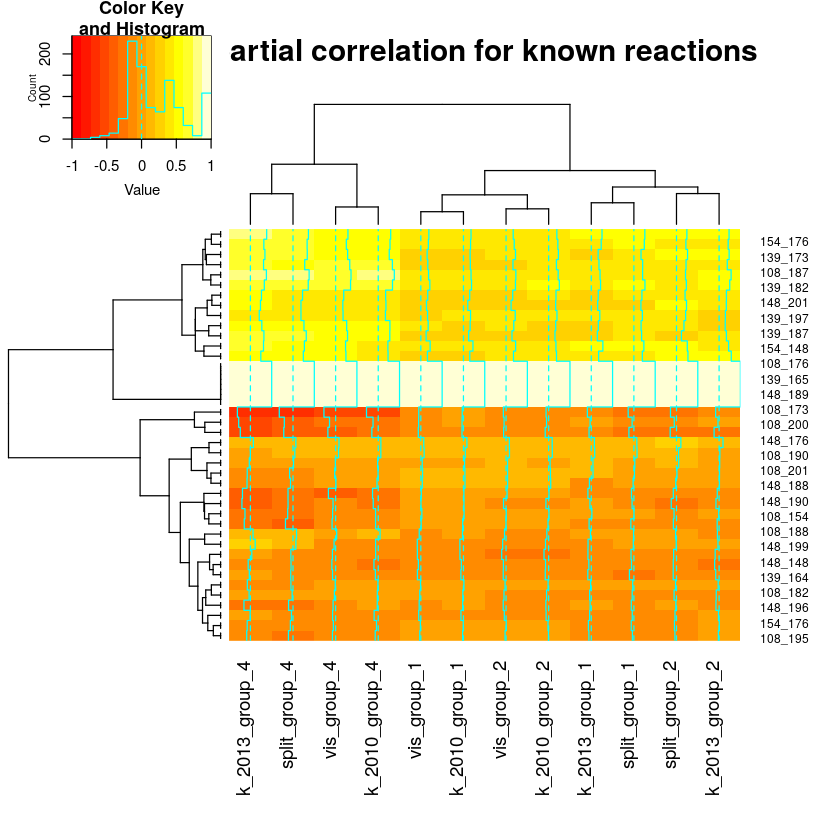

In [995]:
heatmap.2(na.omit(data.matrix(E[,idx<-grepl('ppcor$',colnames(E))])),mar=c(10,5),main='partial correlation for known reactions',
         labRow = paste(E$start,E$end,sep='_'),labCol = gsub('.spearman.ppcor','',colnames(E[,idx])))


Warning message:
“Removed 2272 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2272 rows containing missing values (geom_point).”

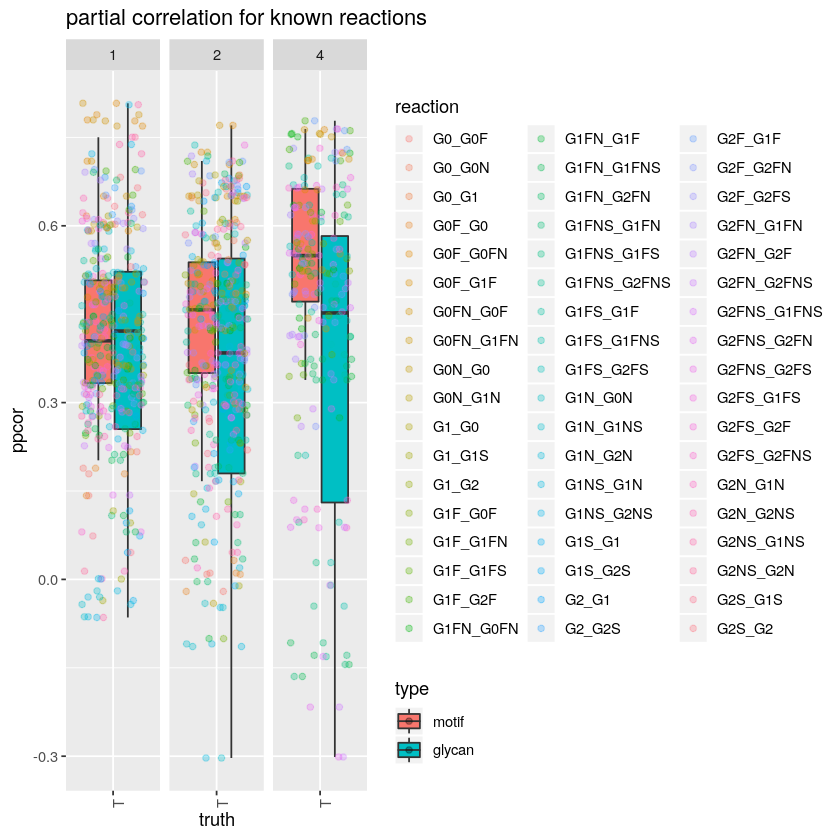

In [996]:

### motifs
m=data.matrix(E[,idx<-grepl('ppcor$',colnames(E))])
rownames(m)= paste(E$start_name,E$end_name,sep='_')
colnames(m)= gsub('.spearman.ppcor','',colnames(E[,idx]))
m = melt(m)
colnames(m)=c('reaction','group','ppcor')
m$igg = str_sub(m$group,str_length(m$group),str_length(m$group))

# g1=ggplot(m,aes(x=reaction,y=ppcor))+geom_boxplot(outlier.shape = NA)+geom_jitter(aes(color=group))+
#     theme(axis.text.x = element_text(angle = 90))+ggtitle('partial correlation for known reactions: MOTIFS')

### glycans
m2=data.matrix(E[,idx<-grepl('ppcor.glycan$',colnames(E))])
rownames(m2)= paste(E$start_name,E$end_name,sep='_')
colnames(m2)= gsub('.spearman.ppcor','',colnames(E[,idx]))
m2 = melt(m2)
colnames(m2)=c('reaction','group','ppcor')
tmp=gsub('.glycan','',m2$group)
m2$igg = str_sub(tmp,str_length(tmp),str_length(tmp))


# g2=ggplot(m2,aes(x=reaction,y=ppcor))+geom_boxplot(outlier.shape = NA)+geom_jitter(aes(color=group))+
#     theme(axis.text.x = element_text(angle = 90))+ggtitle('partial correlation for known reactions: GLYCANS')


## BOTH
m3 = rbind(cbind(type='motif',m),cbind(type='glycan',m2))
m3$group = gsub('.glycan','',m3$group)

# g3=ggplot(m3,aes(x=reaction,y=ppcor,fill=type))+geom_boxplot(outlier.shape = NA)+geom_jitter(aes(color=group))+
#     theme(axis.text.x = element_text(angle = 90))+ggtitle('partial correlation for known reactions')
    #theme_classic()


#################### truth

m3$truth = ifelse(sapply( m3$reaction , function(x){
    out = na.omit(unique(Eall$truth[paste(Eall$start_name,Eall$end_name,sep='_')==x])) 
    ifelse(length(out)>0,out,NA)
})==1,'T','F')

idx = m3$truth%in%c('TP','FP','F','T') & !grepl('^N_|_N$',m3$reaction)
                  
g3b=ggplot(m3[idx,] ,aes(x=truth,y=ppcor,fill=type))+geom_boxplot(outlier.shape = NA)+
                  geom_jitter(aes(color=reaction),alpha=.3)+facet_wrap(~igg)+
    theme(axis.text.x = element_text(angle = 90))+ggtitle('partial correlation for known reactions')
                  
    #theme_classic()
g3b
                  



Warning message:
“Ignoring unknown parameters: outlier.shape”

[1] "motif"


              Df Sum Sq Mean Sq F value Pr(>F)    
truth          1  98.46   98.46    4300 <2e-16 ***
Residuals   3022  69.19    0.02                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

[1] "glycan"


              Df Sum Sq Mean Sq F value Pr(>F)    
truth          1  75.16   75.16    3023 <2e-16 ***
Residuals   3398  84.49    0.02                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Warning message:
“Ignoring unknown parameters: outlier.shape”

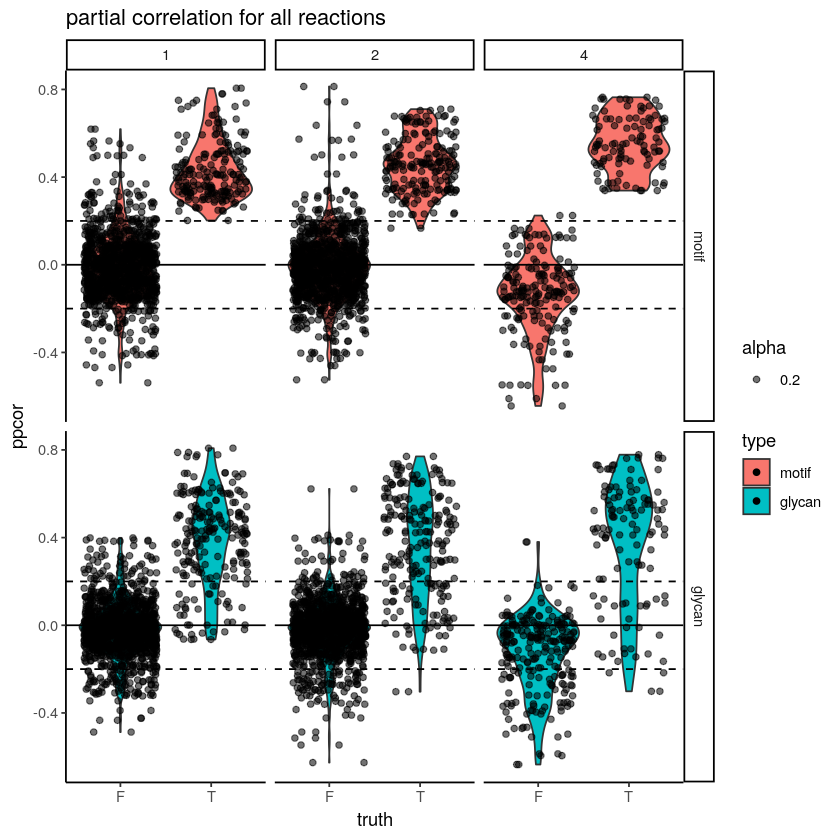

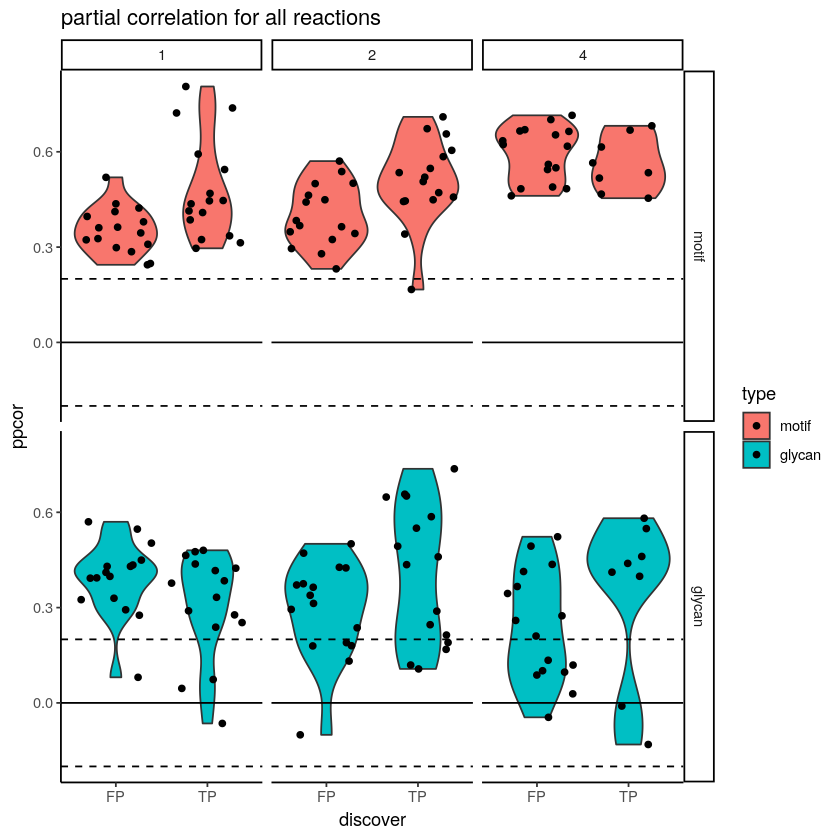

In [1023]:

### motifs
m=data.matrix(Eall[,idx<-grepl('ppcor$',colnames(Eall))])
rownames(m)= paste(Eall$start_name,Eall$end_name,sep='_')
colnames(m)= gsub('.spearman.ppcor','',colnames(Eall[,idx]))
m = melt(m)
colnames(m)=c('reaction','group','ppcor')
m$igg = str_sub(m$group,str_length(m$group),str_length(m$group))

# g1=ggplot(m,aes(x=reaction,y=ppcor))+geom_boxplot(outlier.shape = NA)+geom_jitter(aes(color=group))+
#     theme(axis.text.x = element_text(angle = 90))+ggtitle('partial correlation for known reactions: MOTIFS')

### glycans
m2=data.matrix(Eall[,idx<-grepl('ppcor.glycan$',colnames(Eall))])
rownames(m2)= paste(Eall$start_name,Eall$end_name,sep='_')
colnames(m2)= gsub('.spearman.ppcor','',colnames(Eall[,idx]))
m2 = melt(m2)
colnames(m2)=c('reaction','group','ppcor')
tmp=gsub('.glycan','',m2$group)
m2$igg = str_sub(tmp,str_length(tmp),str_length(tmp))


# g2=ggplot(m2,aes(x=reaction,y=ppcor))+geom_boxplot(outlier.shape = NA)+geom_jitter(aes(color=group))+
#     theme(axis.text.x = element_text(angle = 90))+ggtitle('partial correlation for known reactions: GLYCANS')


## BOTH
m3 = rbind(cbind(type='motif',m),cbind(type='glycan',m2))
m3$group = gsub('.glycan','',m3$group)

# g3=ggplot(m3,aes(x=reaction,y=ppcor,fill=type))+geom_boxplot(outlier.shape = NA)+geom_jitter(aes(color=group))+
#     theme(axis.text.x = element_text(angle = 90))+ggtitle('partial correlation for known reactions')
    #theme_classic()


#################### truth

## benedetti inferred
m3$truth = ifelse(sapply( m3$reaction , function(x){
    out = na.omit(unique(Eall$truth[paste(Eall$start_name,Eall$end_name,sep='_')==x])) 
    ifelse(length(out)>0,out,NA)
})==1,'T','F')

# # bokan base knowledge
# m3$truth = sapply( m3$reaction , function(x){
#     out = na.omit(unique(Eall$truth_bokan_all[paste(Eall$start_name,Eall$end_name,sep='_')==x])) 
#     ifelse(length(out)>0,out,NA)
# })

#m3$truth = ifelse(sapply( m3$reaction , function(x) unique(E$truth[paste(E$start_name,E$end_name,sep='_')==x]))==1,'T','F')



### add tested reactions
e_rxns = paste(E$start_name,E$end_name,sep='_')
e_rxns = ifelse(e_rxns=='NA_NA',NA,e_rxns)
m3$discover = sapply(m3$reaction,function(r){
    if(r=='NA_NA'){return('not-tested')}
    if(r %in% e_rxns){
        if(is.na(unique(E$truth_bokan[which(e_rxns==r)]))){return('not-tested')}
        return(unique(E$truth_bokan[which(e_rxns==r)]))
    }else{
        return('not-tested')
    }
})

### aggregate over regions
# print(dim(m3))
# m3= with(m3, aggregate(ppcor,by=list(type,reaction,igg,truth,discover,group),mean,na.rm=T) )
# colnames(m3)=c('type','reaction','igg','truth','discover','group','ppcor')
# head(m3)
# print(dim(m3))

idx = m3$truth%in%c('TP','FP','F','T') & !grepl('^N_|_N$',m3$reaction)


g3b=ggplot(unique(na.omit(m3[idx,])) ,aes(x=truth,y=ppcor,fill=type))+
    geom_violin(outlier.shape = NA)+
    geom_jitter(aes(group=type,alpha=.2))+ #alpha=ifelse(discover=='not-tested',.3,1)))+
    facet_grid(type~igg)+
    geom_hline(yintercept = 0)+geom_hline(yintercept = c(-.2,.2),lty=2)+
#    scale_color_manual(values = c('red','black','blue'))+
    theme(axis.text.x = element_text(angle = 90))+ggtitle('partial correlation for all reactions')+
    theme_classic()
                  
g3b

print('motif')         
summary(aov( ppcor ~ truth , data=na.omit(m3[idx & m3$type=='motif',])))
print('glycan')
summary(aov( ppcor ~ truth , data=na.omit(m3[idx & m3$type=='glycan',])))



g3c=ggplot(unique(na.omit(m3[idx & m3$discover!='not-tested',])) ,aes(x=discover,y=ppcor,fill=type))+
    geom_violin(outlier.shape = NA)+
    geom_jitter(aes(group=type))+
    facet_grid(type~igg)+
    geom_hline(yintercept = 0)+geom_hline(yintercept = c(-.2,.2),lty=2)+
    #scale_color_manual(values = c('red','black','blue'))+
    theme(axis.text.x = element_text(angle = 90))+ggtitle('partial correlation for all reactions')+
    theme_classic()
                  
g3c
                  
                  

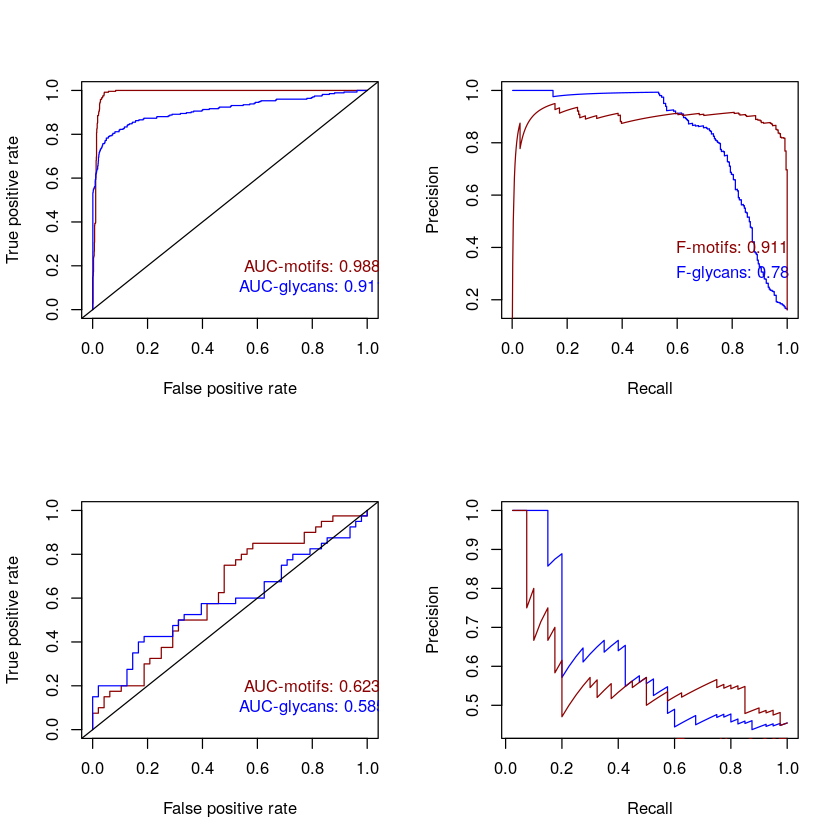

In [1017]:
library(ROCR)

par(mfrow=c(2,2))

### roc 
pred1 <- prediction(m3$ppcor[idx&m3$type=='motif'], labels = ifelse(m3$truth[idx&m3$type=='motif']=='T',1,0))
perf1 <- performance(pred1, measure = "tpr", x.measure = "fpr")
perf1a <- performance(pred1, measure = "auc")
plot(perf1, col='darkred')
text(.8,.2,paste('AUC-motifs:',signif(perf1a@y.values[[1]],3)),col='darkred')

pred2 <- prediction(m3$ppcor[idx&m3$type=='glycan'], labels = ifelse(m3$truth[idx&m3$type=='glycan']=='T',1,0))
perf2 <- performance(pred2, measure = "tpr", x.measure = "fpr")
perf2a <- performance(pred2, measure = "auc")
plot(perf2, col='blue',add=T)
text(.8,.1,paste('AUC-glycans:',signif(perf2a@y.values[[1]],3)),col='blue')
abline(0,1)


#### percision recall

pred2 <- prediction(m3$ppcor[idx&m3$type=='glycan'], labels = ifelse(m3$truth[idx&m3$type=='glycan']=='T',1,0))
perf2 <- performance(pred2, measure = "prec", x.measure = "rec")
perf2a <- performance(pred2, measure = "f")
plot(perf2, col='blue',add=F)
text(.8,.3,paste('F-glycans:',signif(max(na.omit(perf2a@y.values[[1]])),3)),col='blue')

pred1 <- prediction(m3$ppcor[idx&m3$type=='motif'], labels = ifelse(m3$truth[idx&m3$type=='motif']=='T',1,0))
perf1 <- performance(pred1, measure = "prec", x.measure = "rec")
perf1a <- performance(pred1, measure = "f")
plot(perf1, col='darkred',add=T)
text(.8,.4,paste('F-motifs:',signif(max(na.omit(perf1a@y.values[[1]])),3)),col='darkred')


#####################
idx_g = idx&m3$discover!='not-tested' & idx&m3$type=='glycan'
idx_m = idx&m3$discover!='not-tested' & idx&m3$type=='motif'

### roc 
pred1 <- prediction(m3$ppcor[idx_m], labels = ifelse(m3$discover[idx_m]=='TP',1,0))
perf1 <- performance(pred1, measure = "tpr", x.measure = "fpr")
perf1a <- performance(pred1, measure = "auc")
plot(perf1, col='darkred')
text(.8,.2,paste('AUC-motifs:',signif(perf1a@y.values[[1]],3)),col='darkred')

pred2 <- prediction(m3$ppcor[idx_g], labels = ifelse(m3$discover[idx_g]=='TP',1,0))
perf2 <- performance(pred2, measure = "tpr", x.measure = "fpr")
perf2a <- performance(pred2, measure = "auc")
plot(perf2, col='blue',add=T)
text(.8,.1,paste('AUC-glycans:',signif(perf2a@y.values[[1]],3)),col='blue')
abline(0,1)


#### percision recall

pred2 <- prediction(m3$ppcor[idx_g], labels = ifelse(m3$discover[idx_g]=='TP',1,0))
perf2 <- performance(pred2, measure = "prec", x.measure = "rec")
perf2a <- performance(pred2, measure = "f")
plot(perf2, col='blue',add=F)
text(.8,.3,paste('F-glycans:',signif(max(na.omit(perf2a@y.values[[1]])),3)),col='blue')

pred1 <- prediction(m3$ppcor[idx_m], labels = ifelse(m3$discover[idx_m]=='TP',1,0))
perf1 <- performance(pred1, measure = "prec", x.measure = "rec")
perf1a <- performance(pred1, measure = "f")
plot(perf1, col='darkred',add=T)
text(.8,.4,paste('F-motifs:',signif(max(na.omit(perf1a@y.values[[1]])),3)),col='darkred')








### distribution of reactions

,Group.1,x,name,only_in_Eall
,<fct>,<dbl>,<chr>,<lgl>
20,G1FN_G1FS,0.4289993,integer(0)_integer(0),FALSE
35,G1FS_G1FN,0.4289993,integer(0)_integer(0),FALSE
46,G2F_G2FN,0.3849198,integer(0)_integer(0),FALSE
54,G2FN_G2F,0.3849198,integer(0)_integer(0),FALSE
56,G2FN_G2FS,0.3621185,integer(0)_integer(0),FALSE
63,G2FS_G2FN,0.3621185,integer(0)_integer(0),FALSE
6,G0FN_G2FN,0.1103377,integer(0)_integer(0),FALSE
49,G2FN_G0FN,0.1103377,integer(0)_integer(0),FALSE
31,G1FNS_G2FNS,0.1084111,integer(0)_integer(0),FALSE


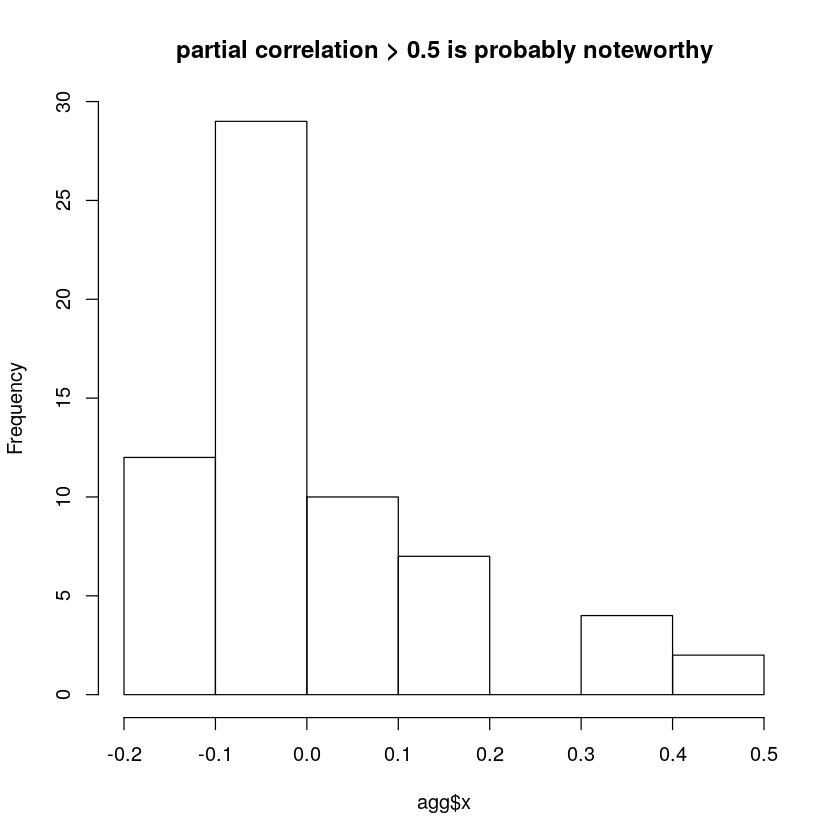

In [446]:
agg = aggregate(m2$ppcor,by=list(m2$reaction),median)
agg$name=sapply(agg$Group.1,function(x){
    paste(sapply(
        strsplit(as.character(x),'_')[[1]] , function(y){
            N$if_glycan[ N$index %in% y ]
                                       }),collapse = '_')})
agg = agg[agg$x<1,]
agg$only_in_Eall = !agg$Group.1 %in% m$reaction
head(agg[order(-agg$x),],n=10)
hist(agg$x,main='partial correlation > 0.5 is probably noteworthy')

### All substructure ratios vary from 0-1 with a median around 0.45

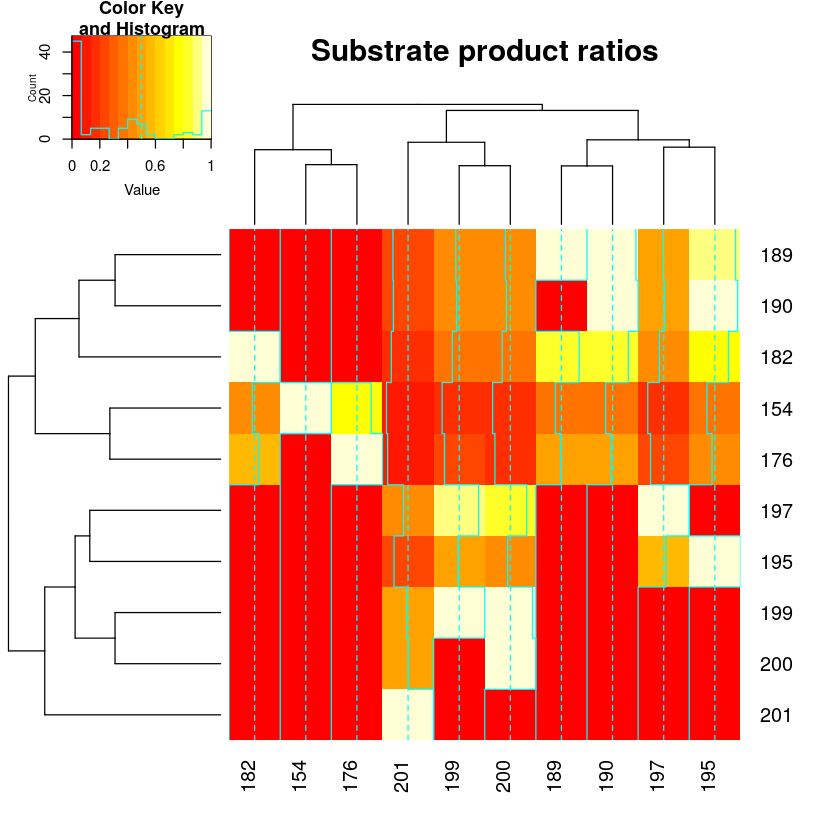

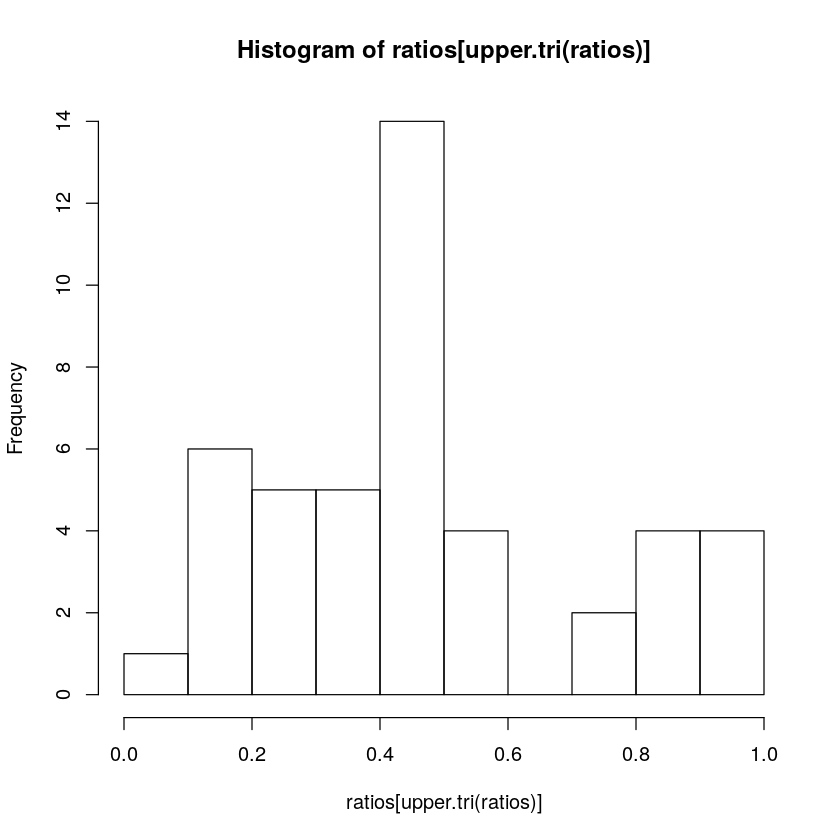

In [282]:
#### results unclear, removed
## distribution of product-reactant ratios
ratios<-apply(X,2,function(x)colMeans(x/X))
ratios[lower.tri(ratios)]=0
heatmap.2(ratios,main='Substrate product ratios')
hist(ratios[upper.tri(ratios)])

### Visualization of partial correlation: heatmap, highest and mapped onto the know reaction network

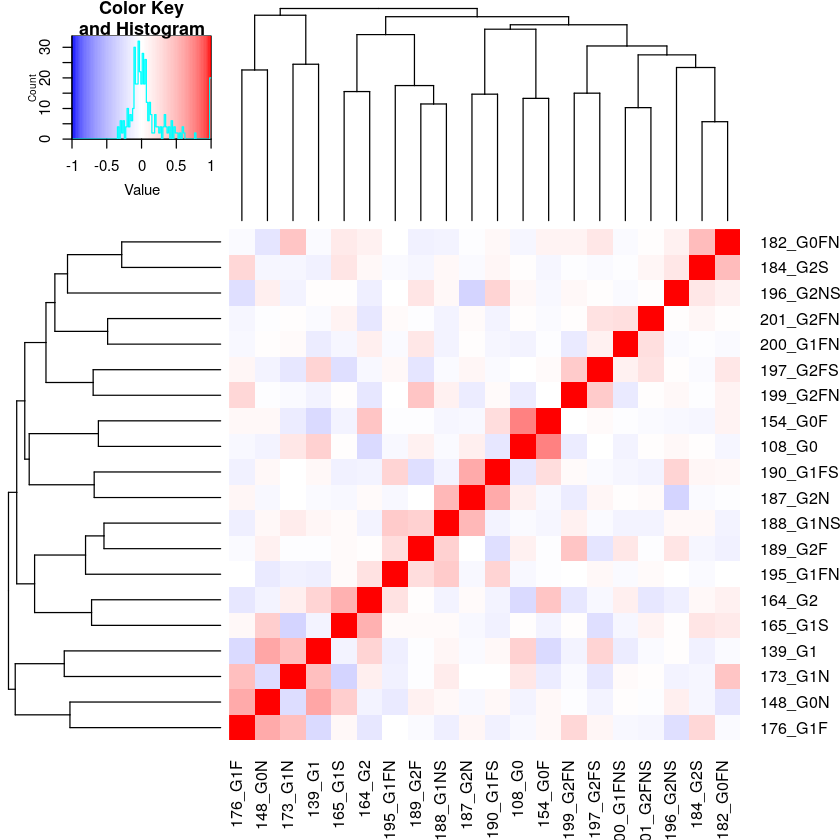

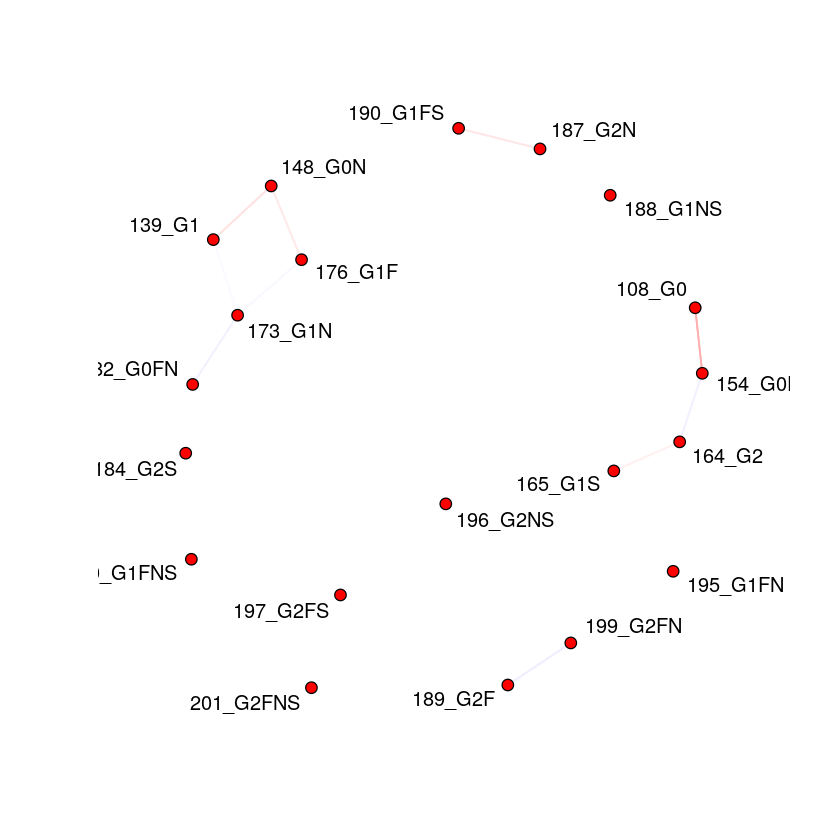

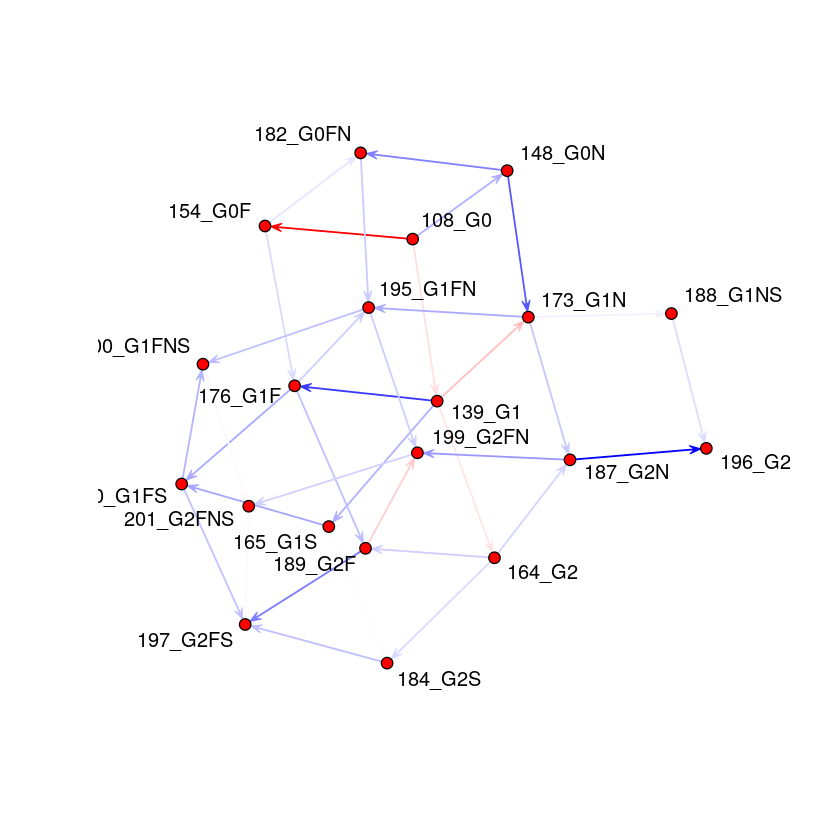

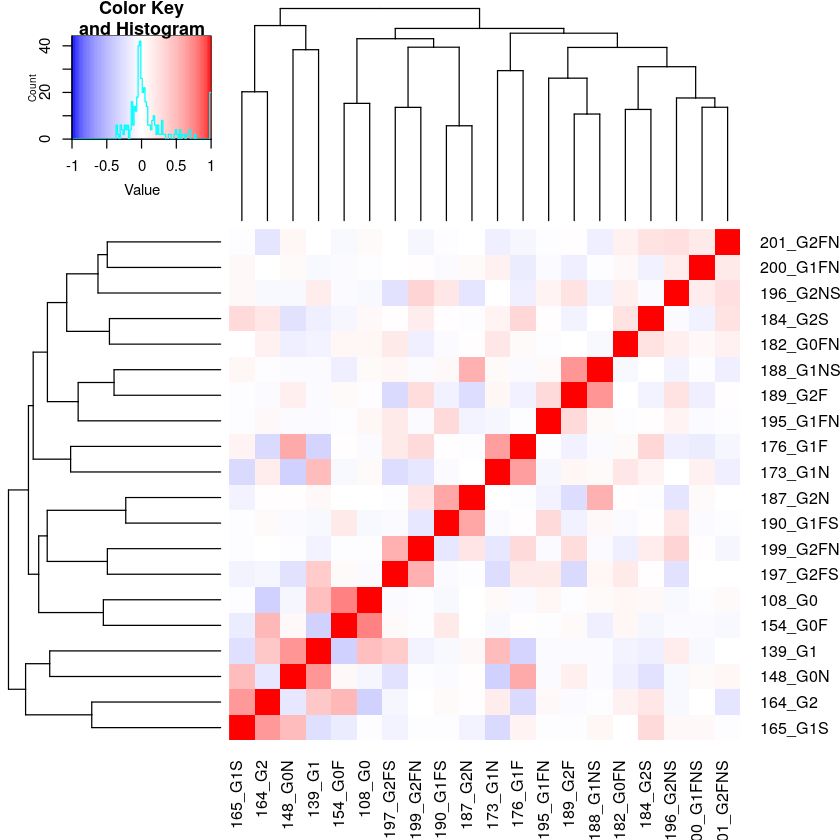

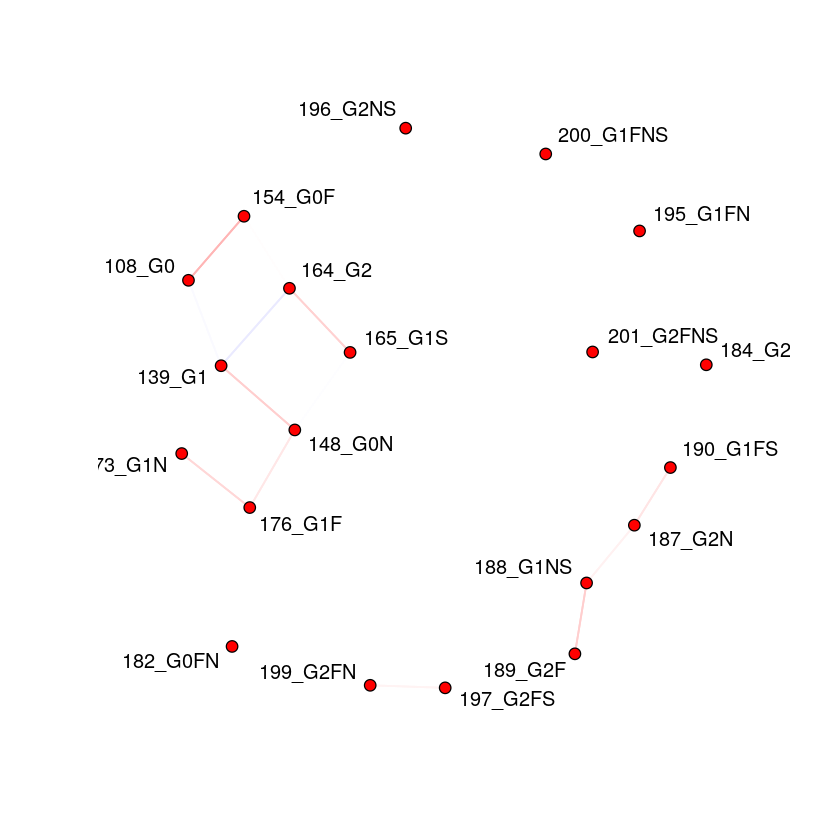

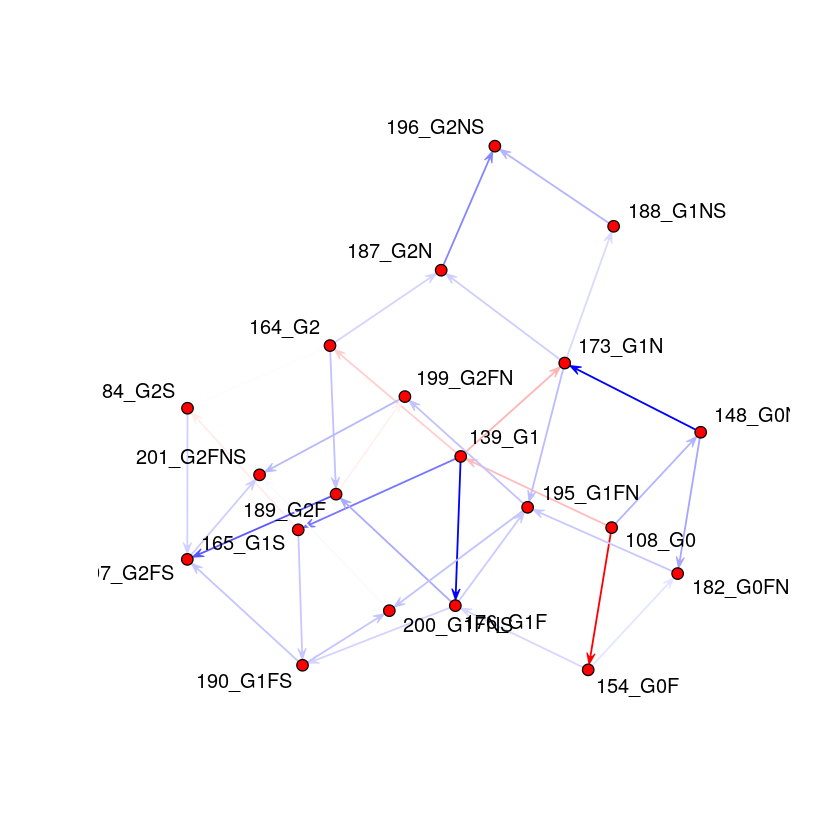

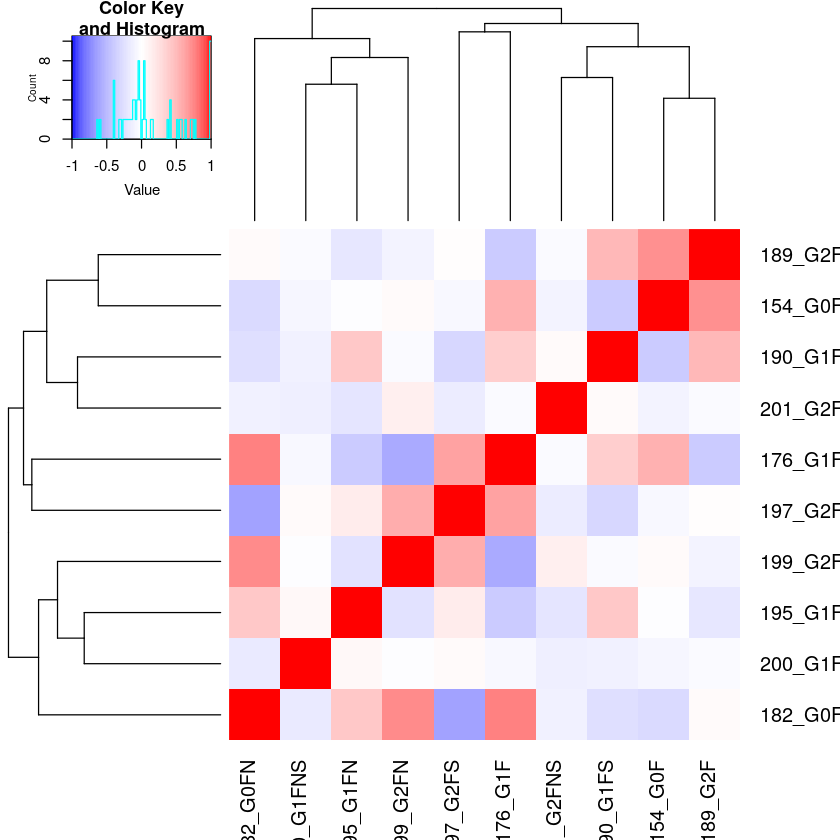

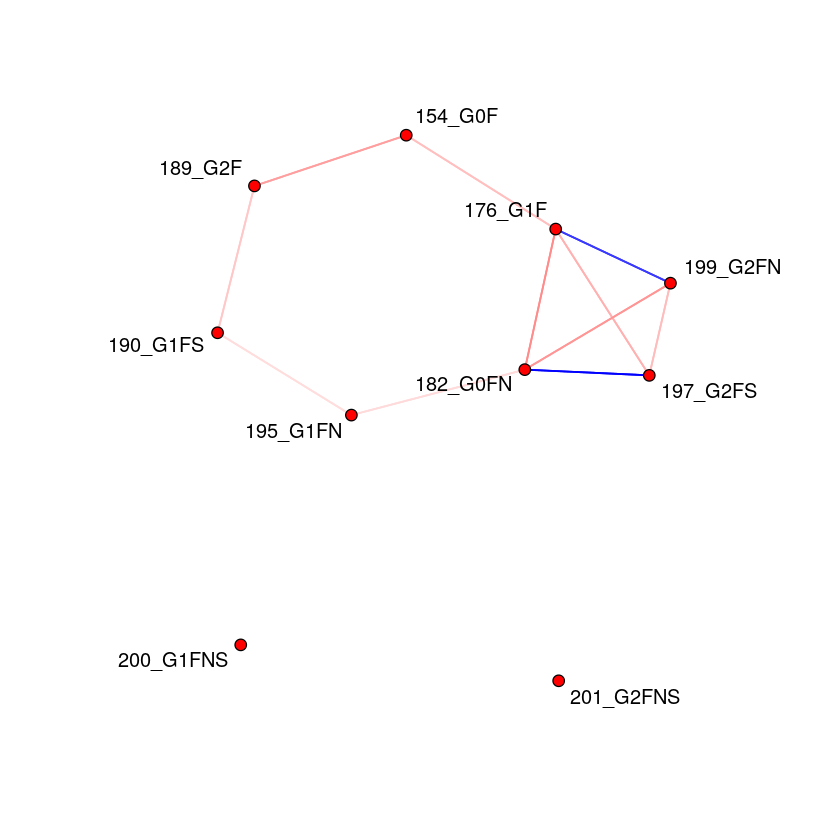

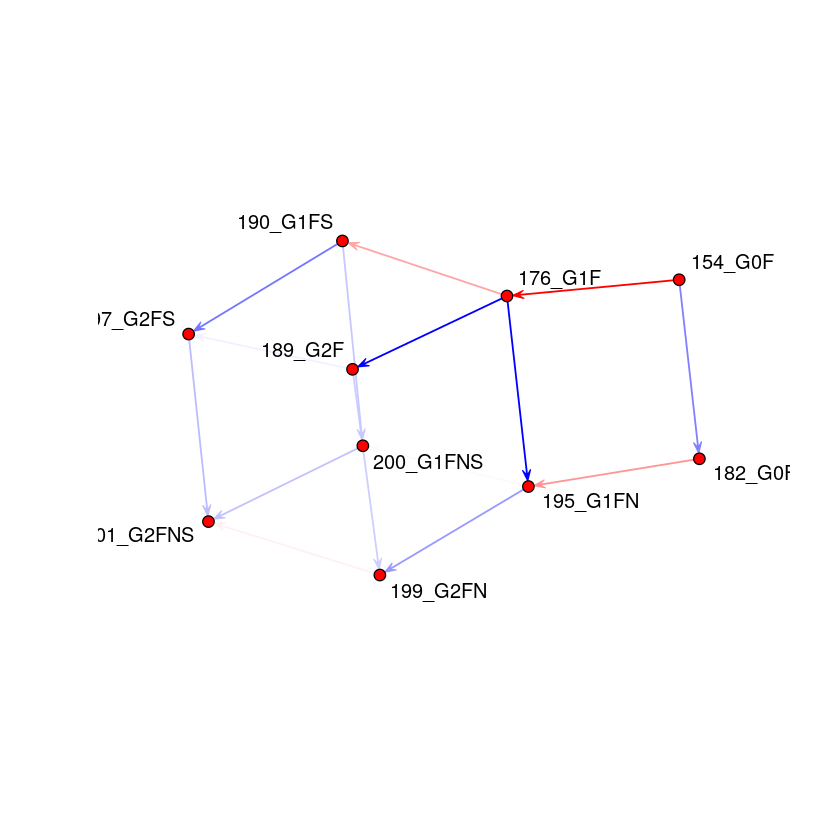

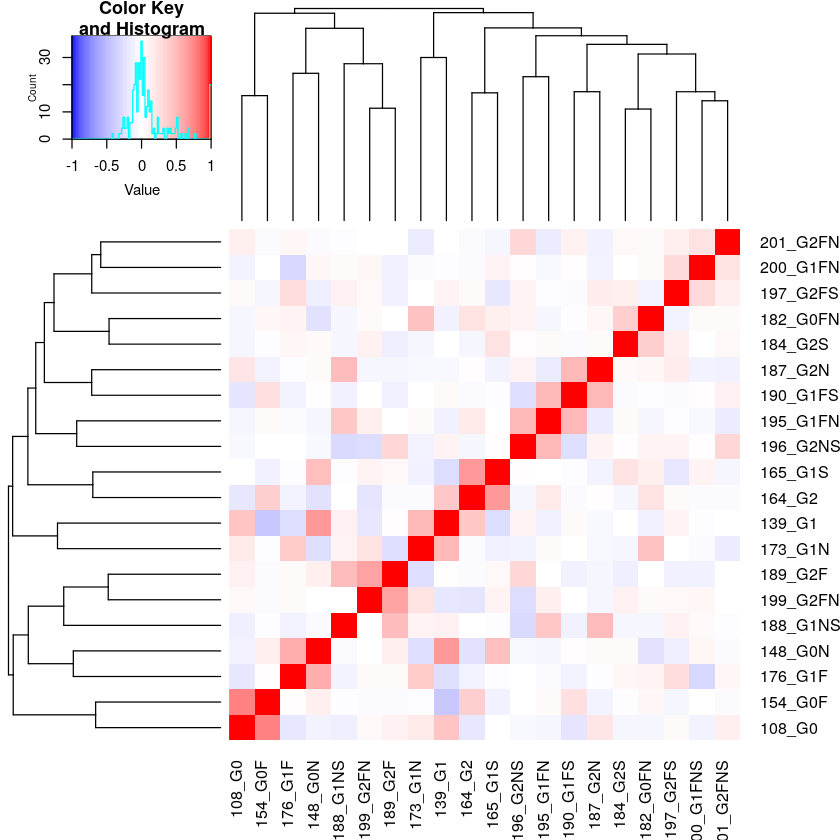

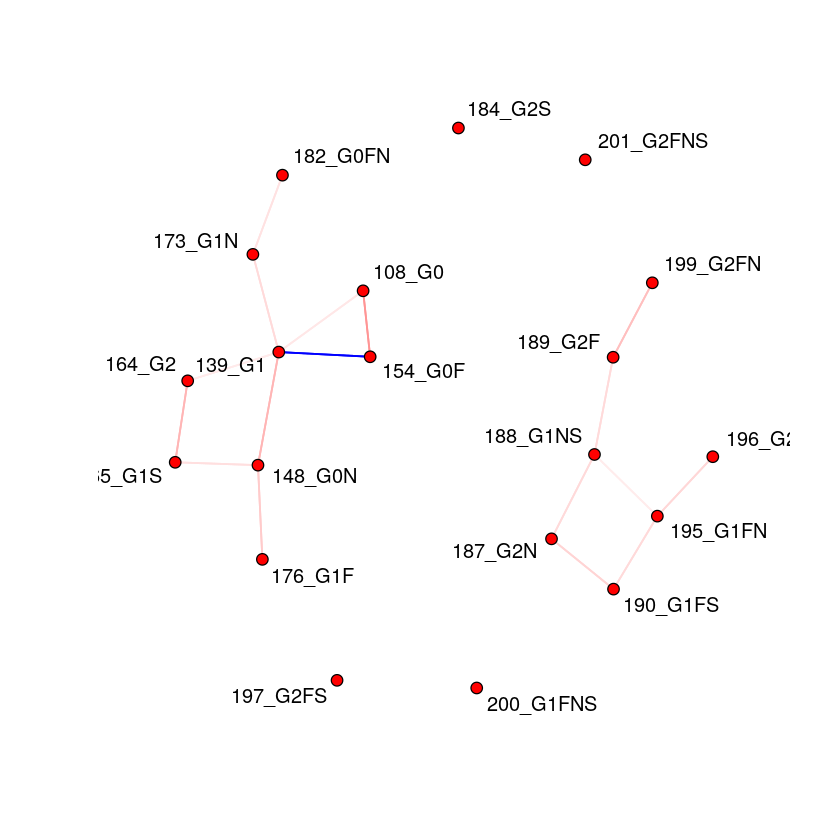

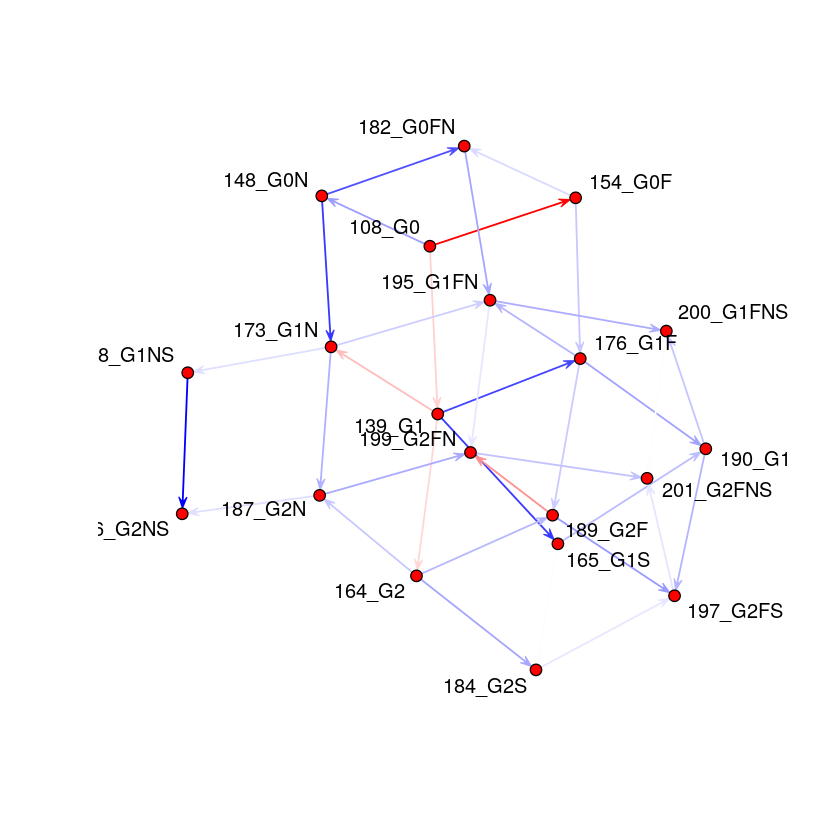

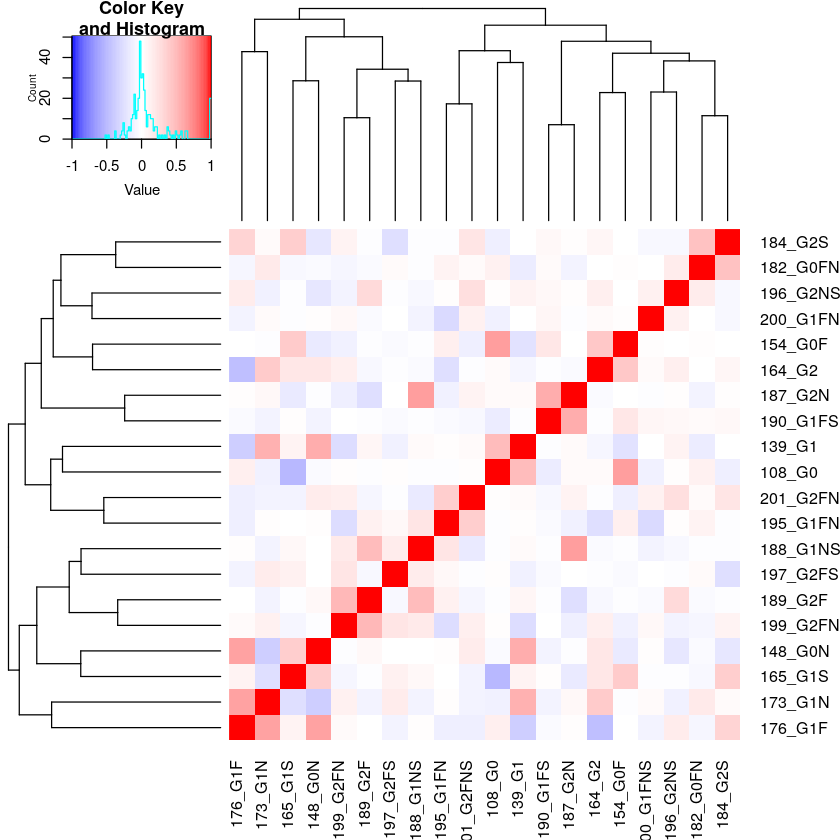

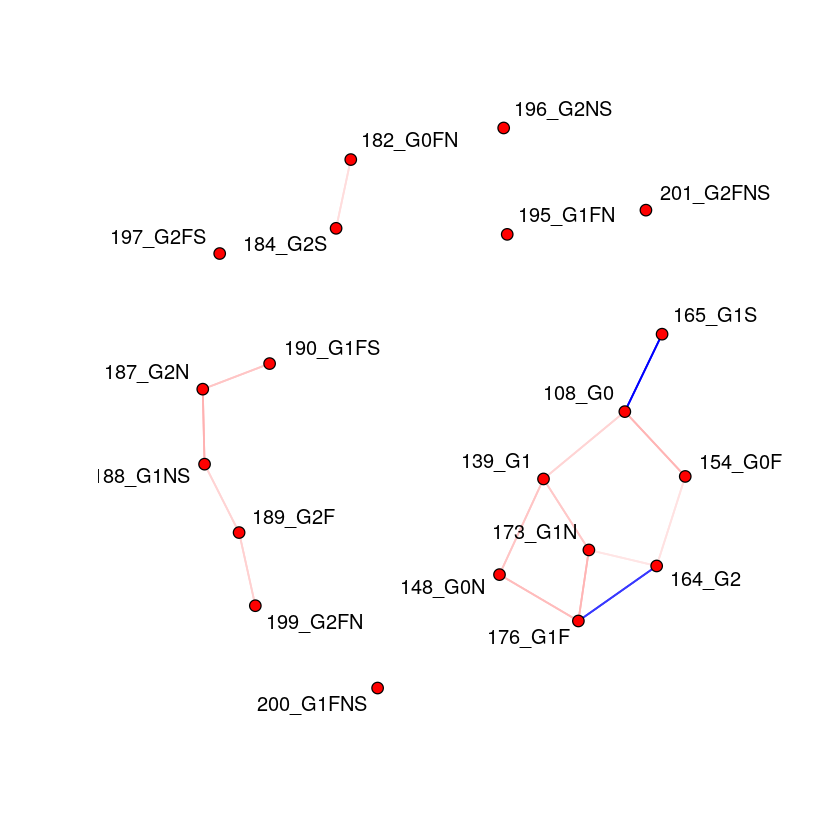

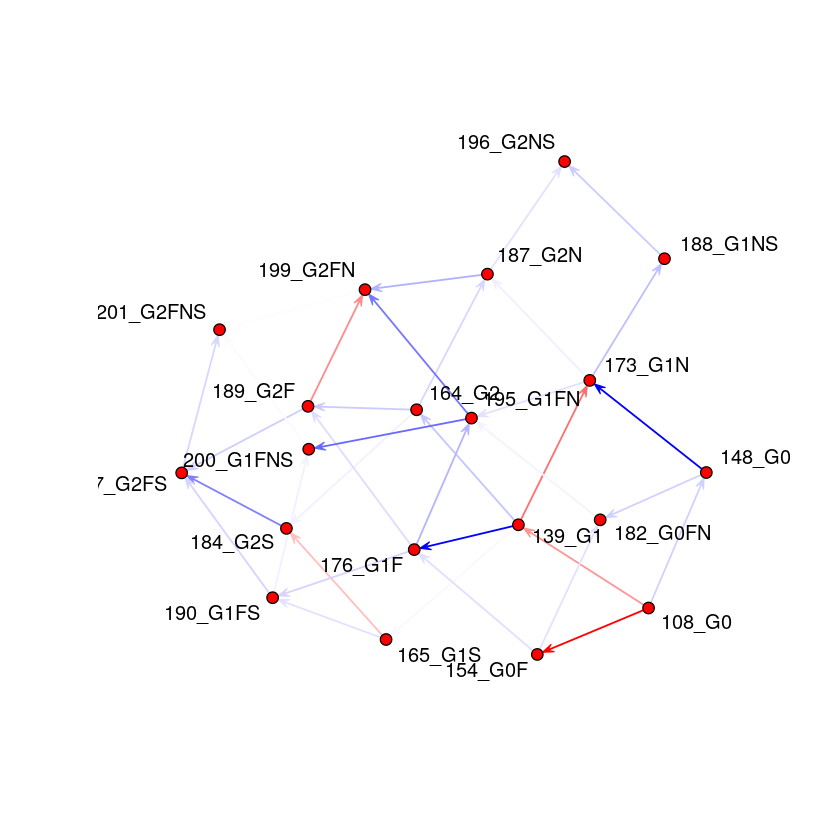

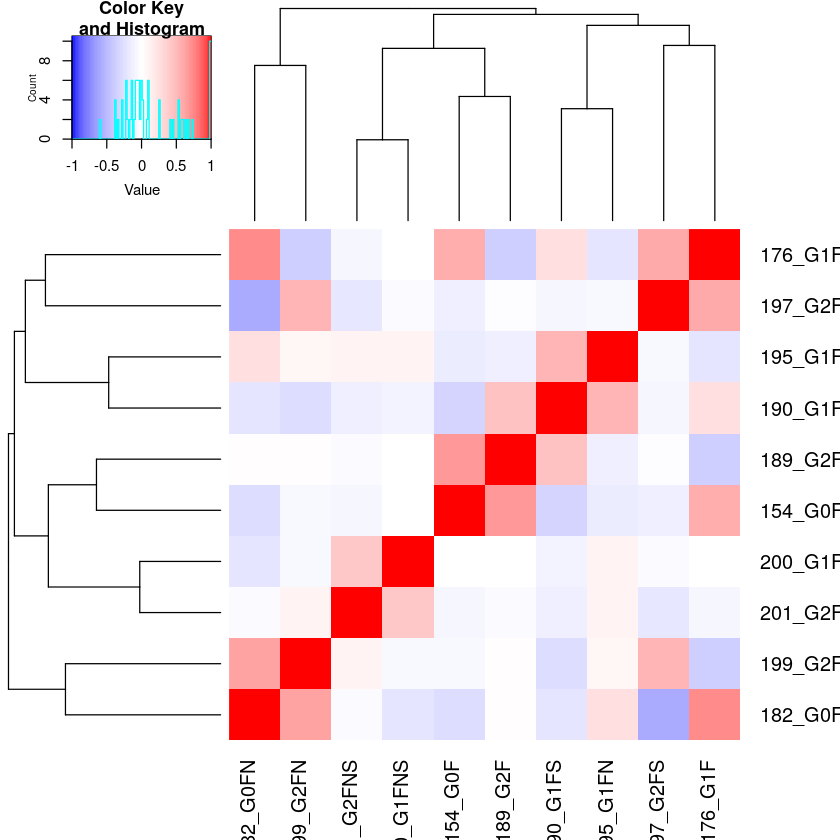

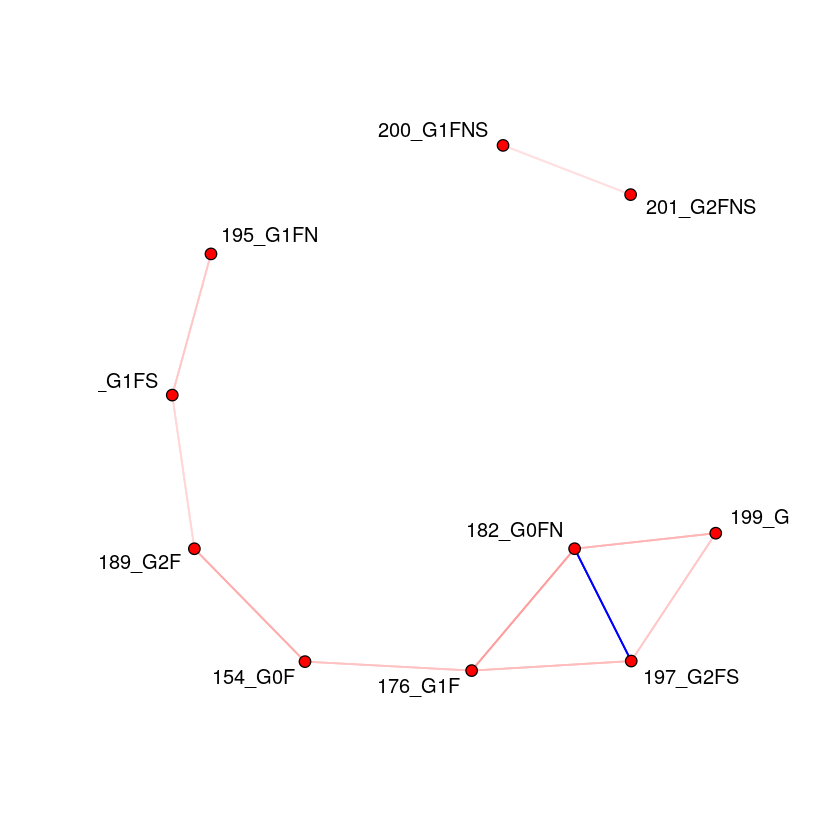

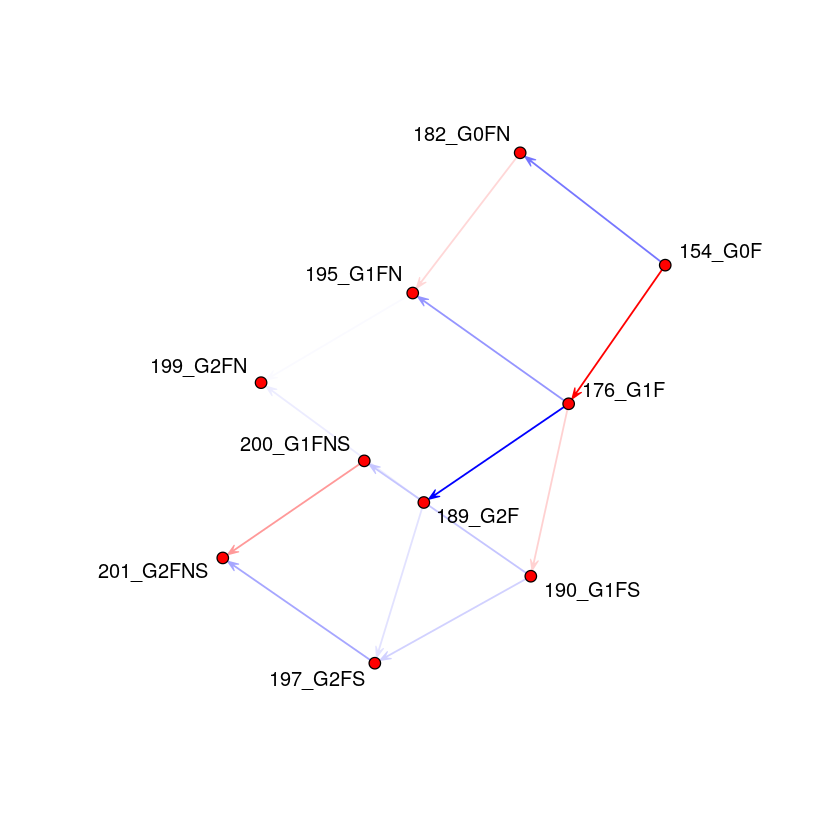

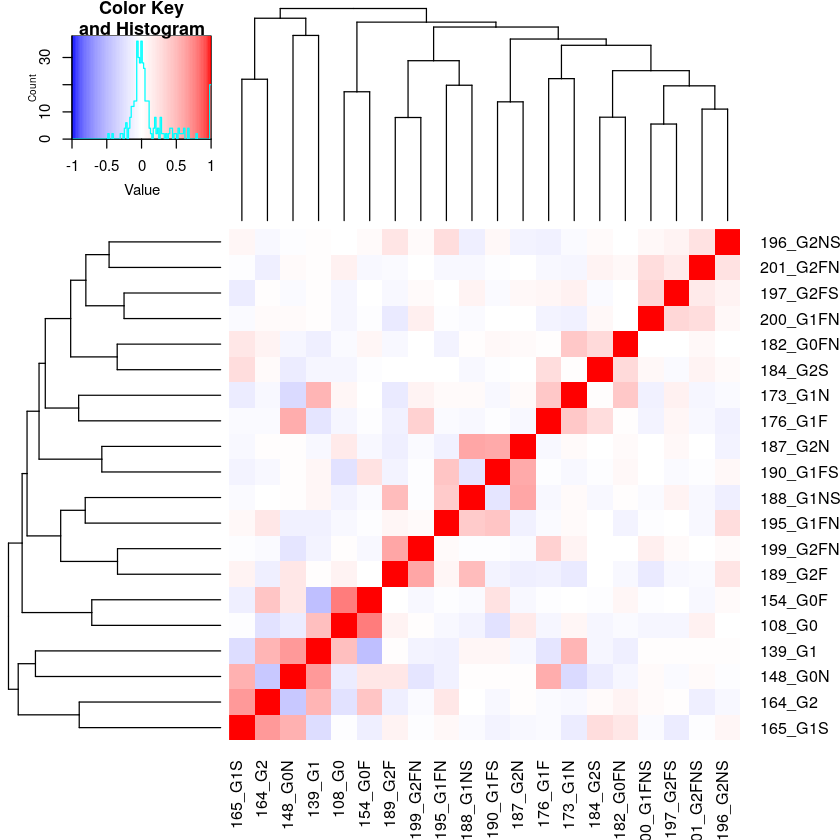

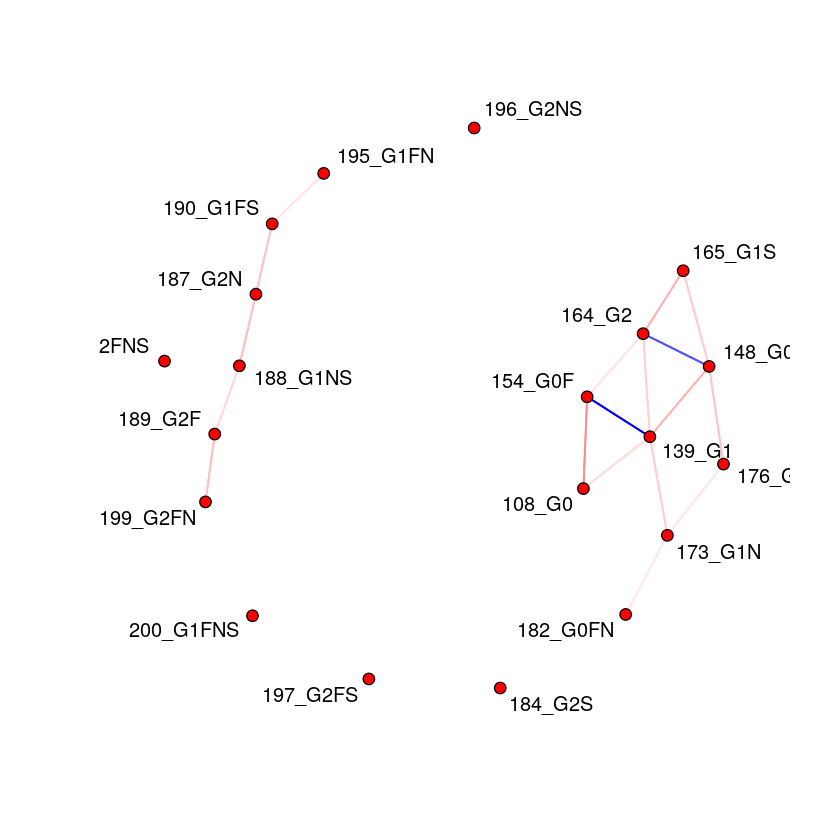

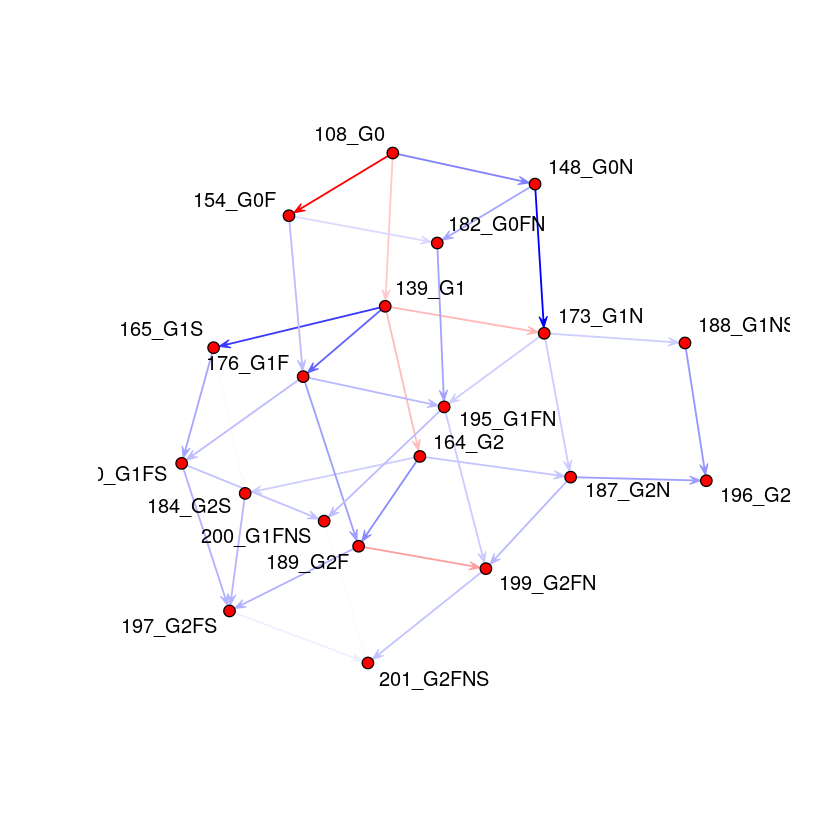

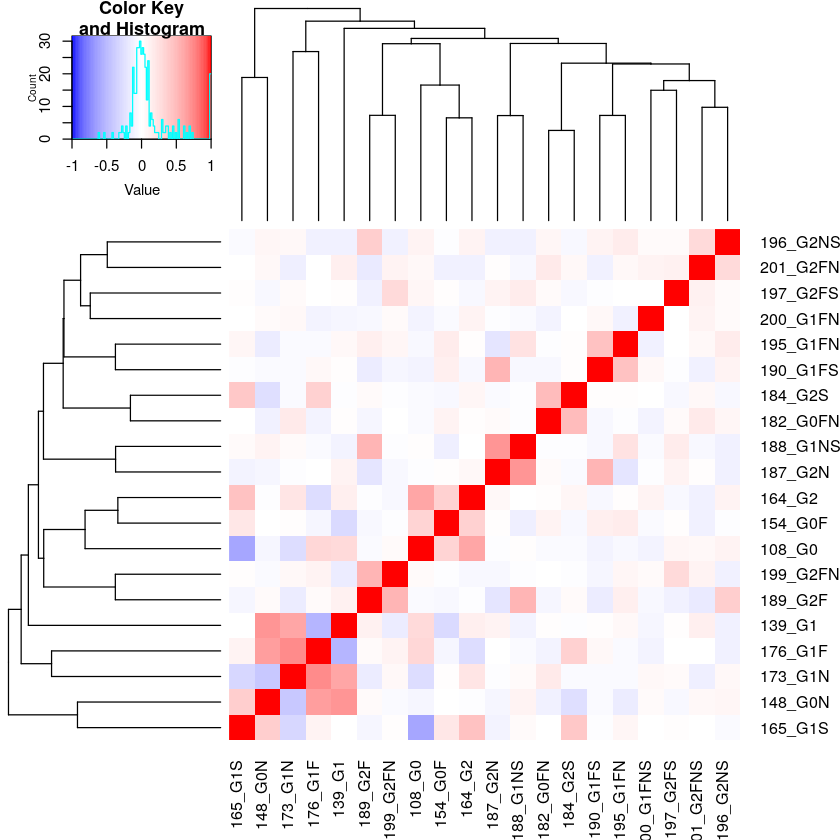

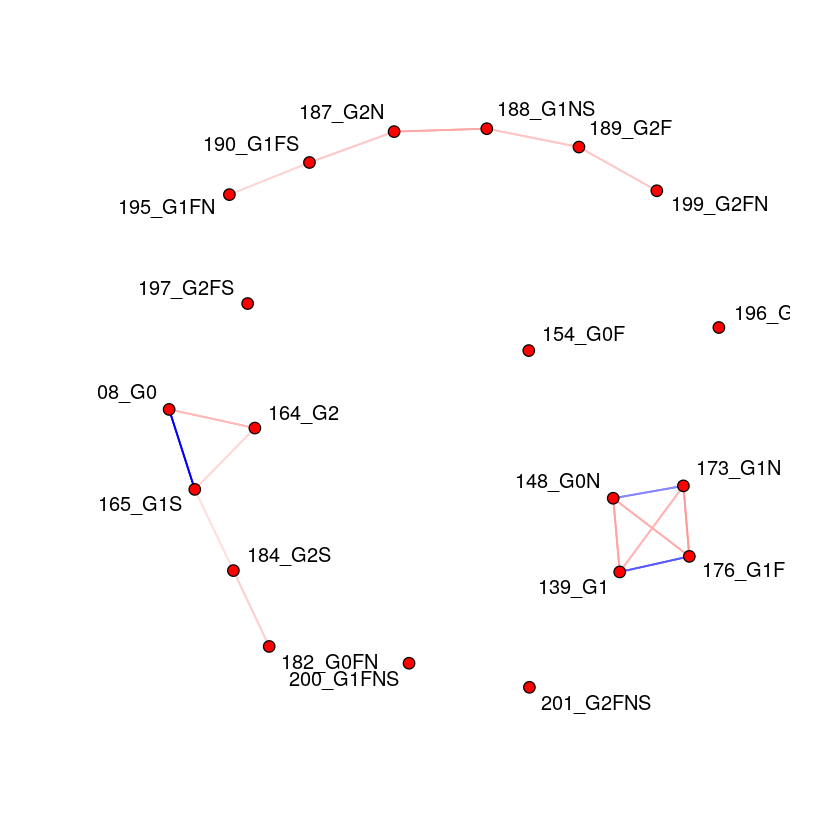

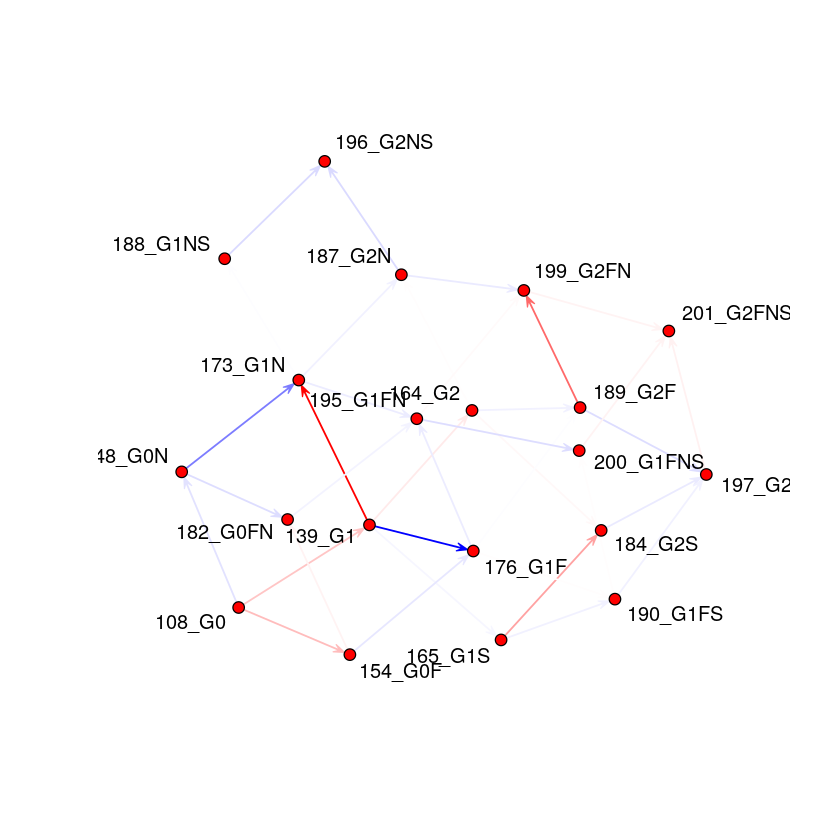

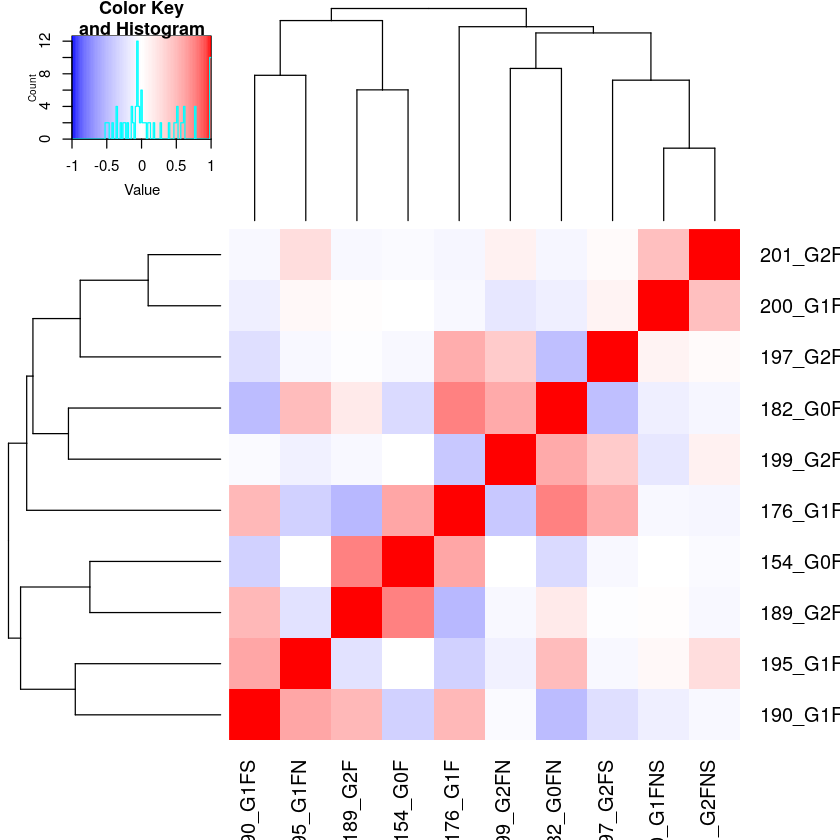

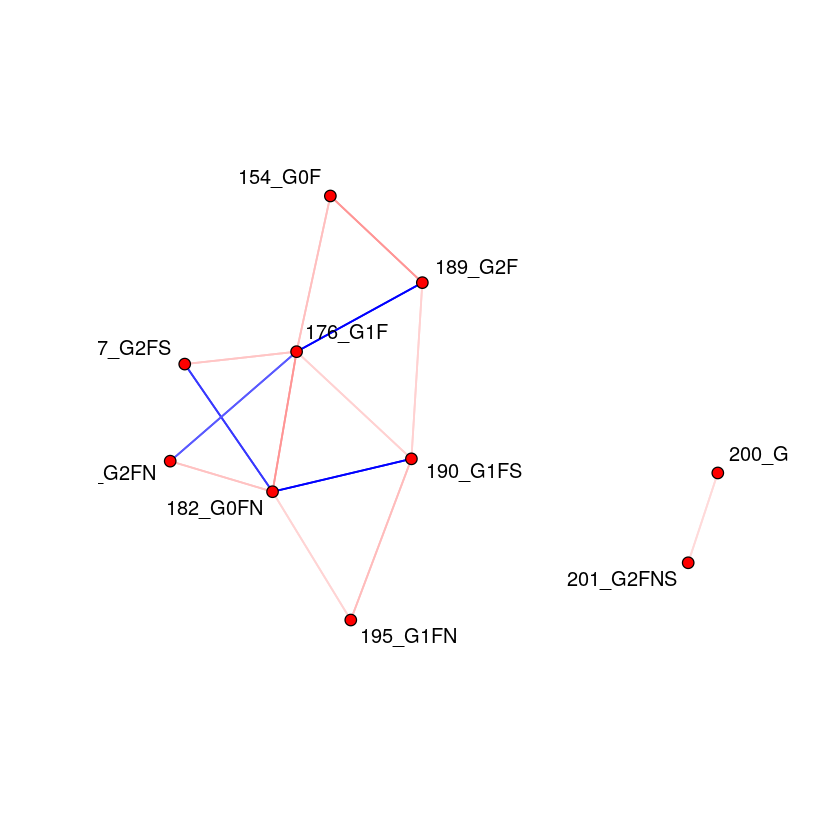

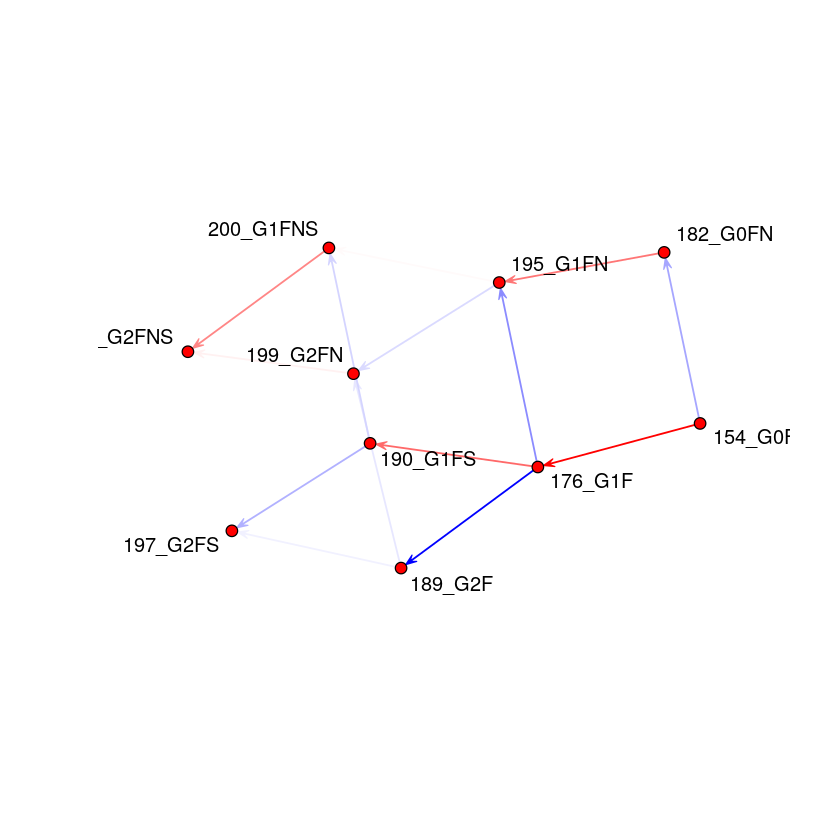

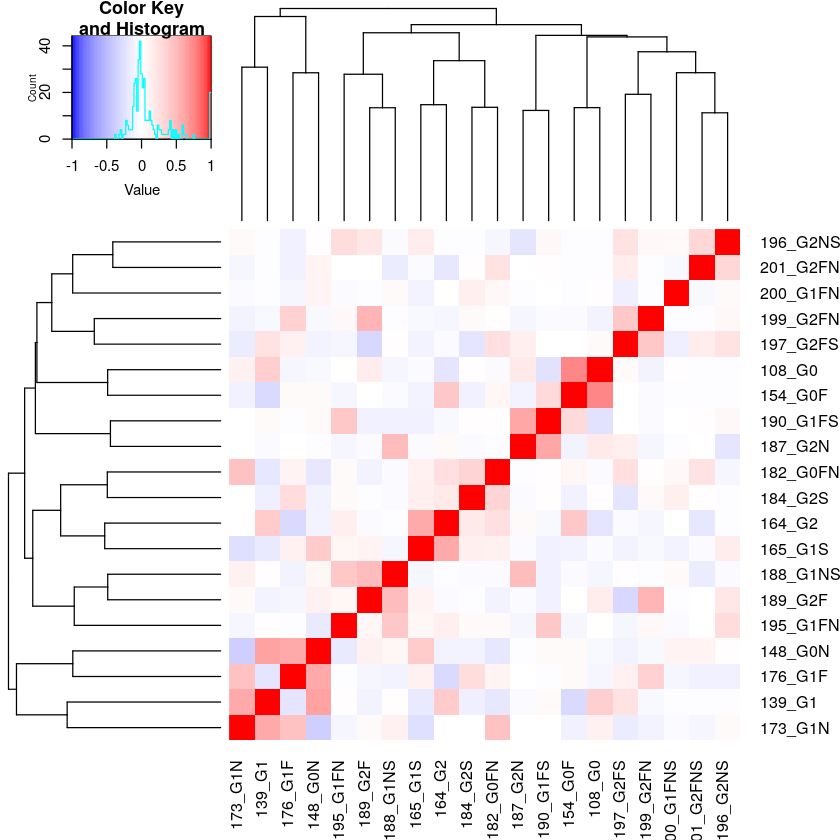

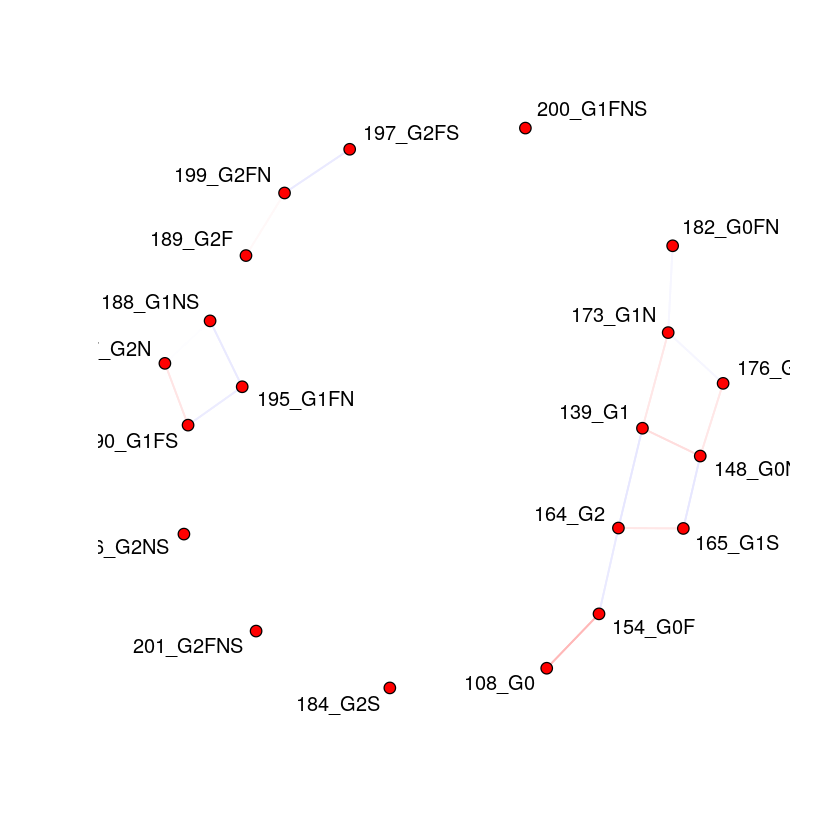

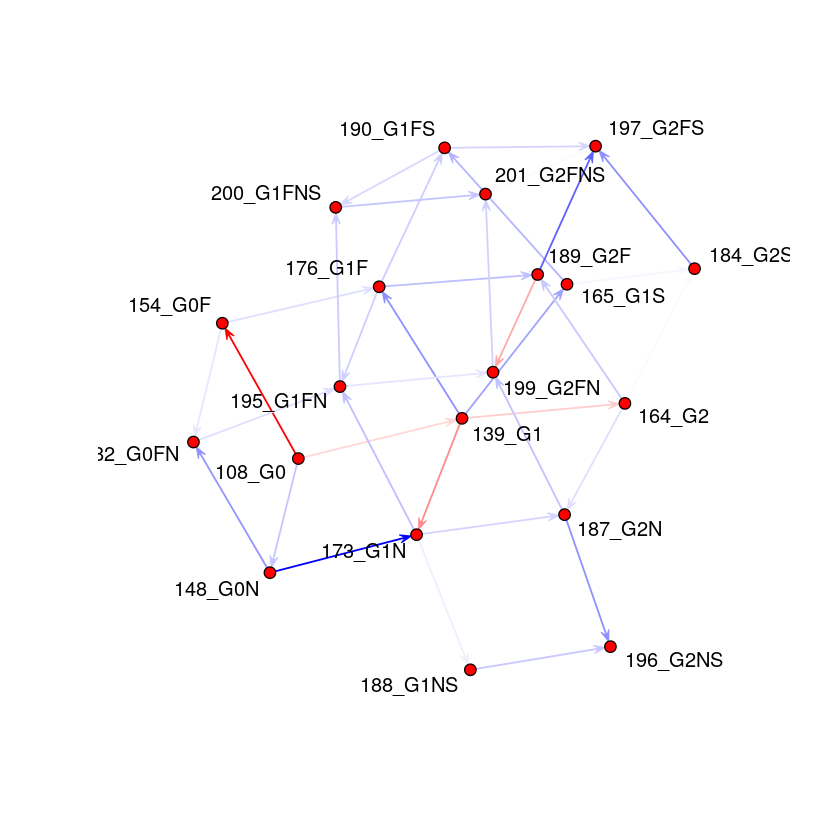

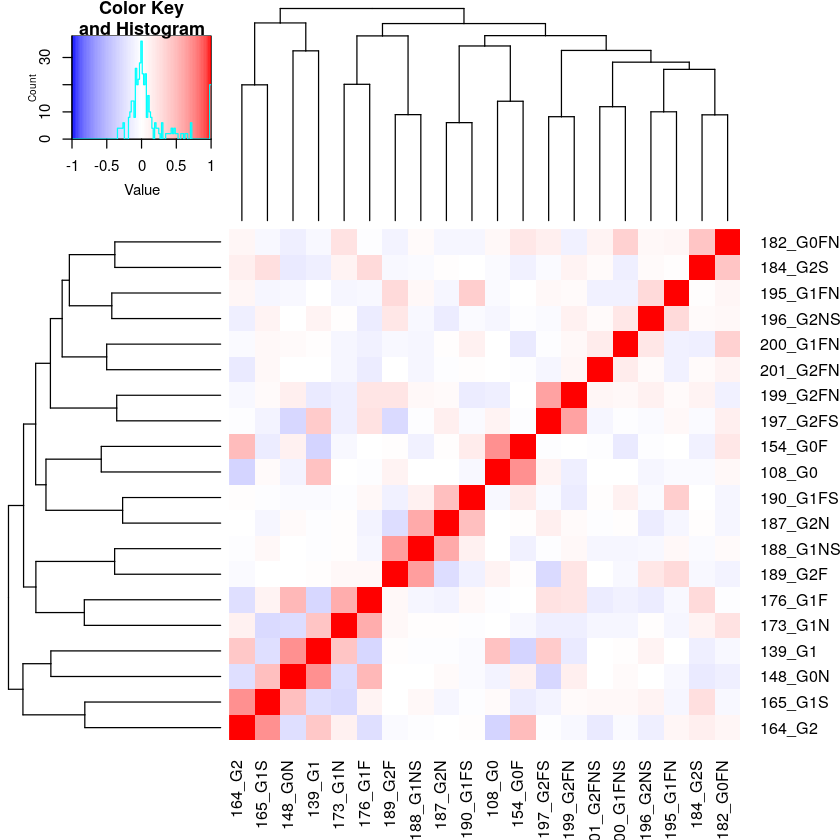

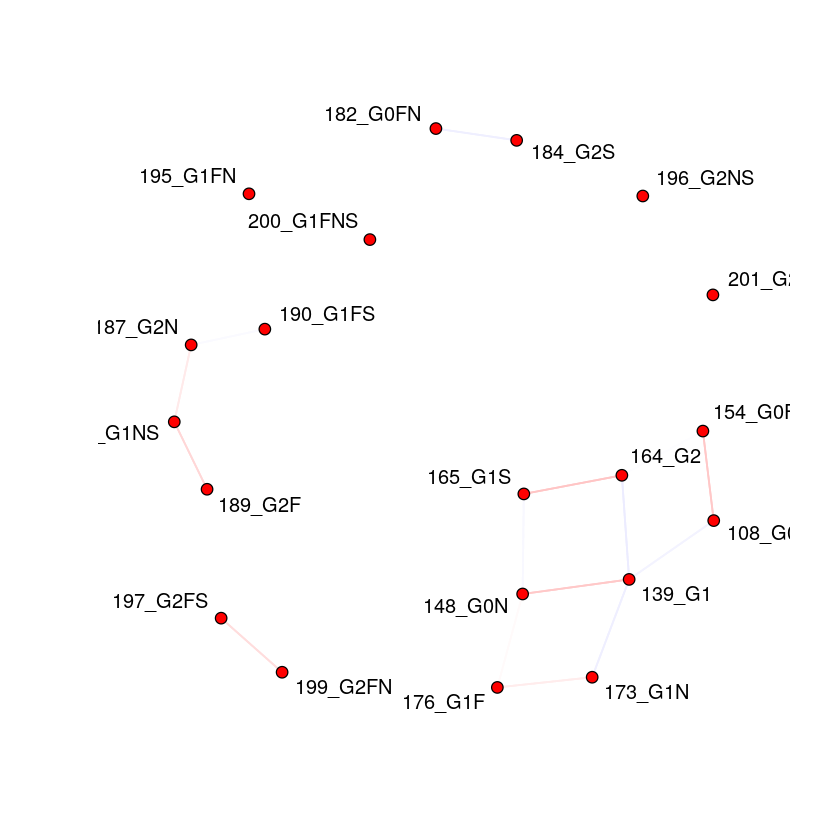

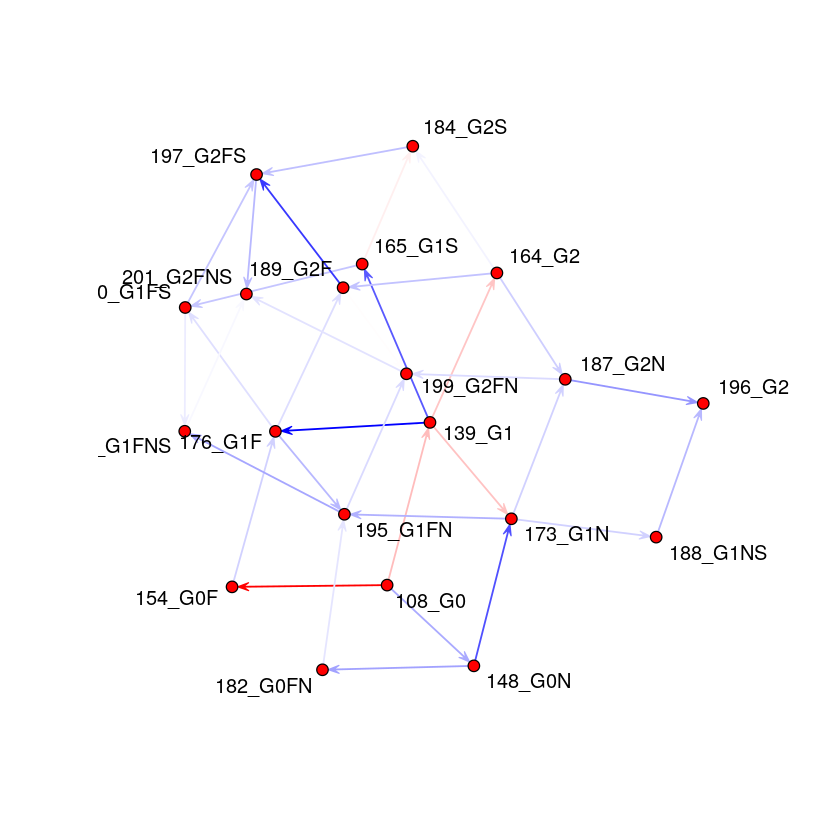

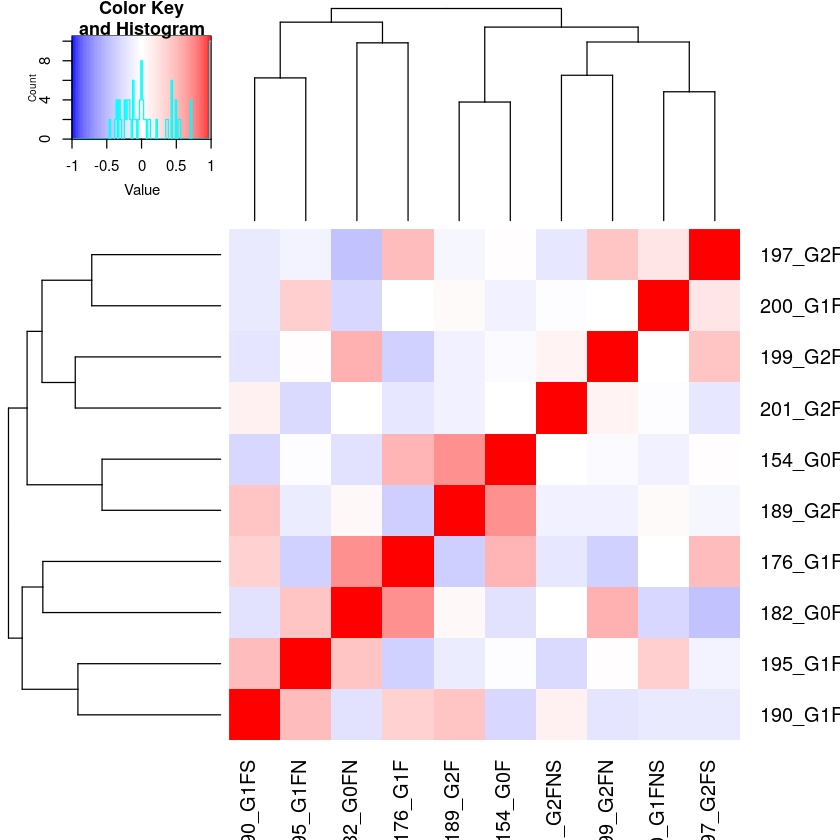

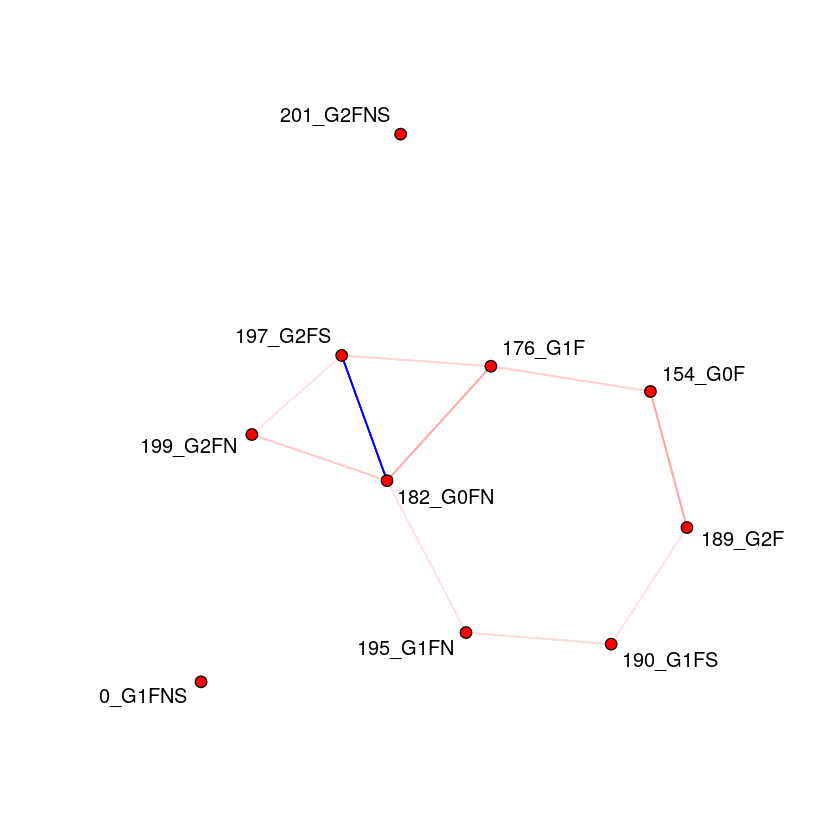

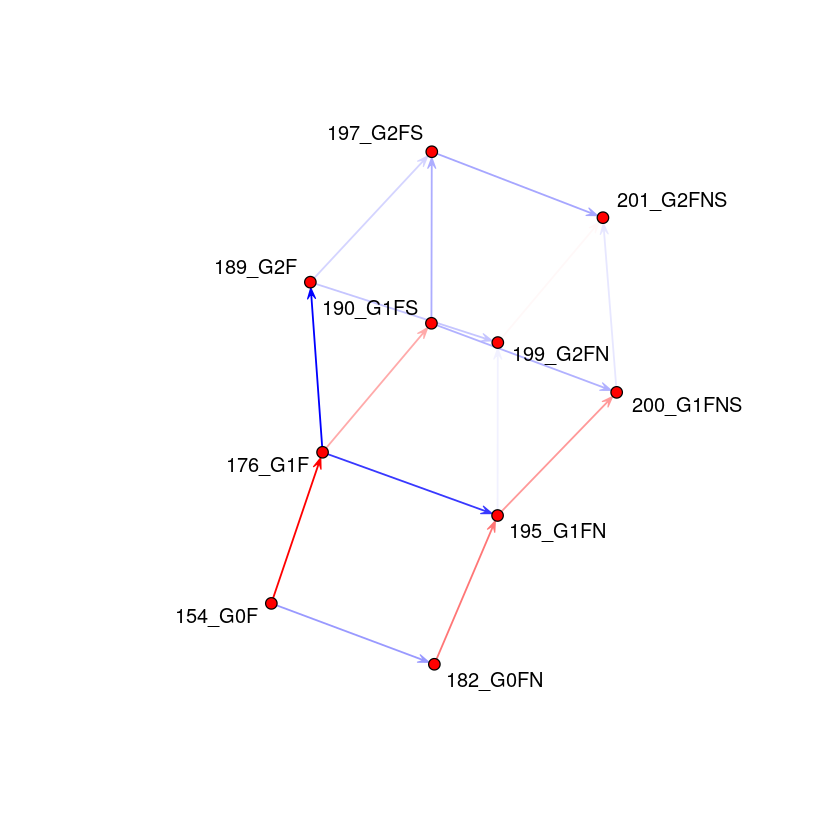

In [578]:
### visualize
for(i in 1:length(nets)){
    # heatmap
    heatmap.2(data.matrix(nets[[i]]$partial_correlation),trace='none',col=colorspace::diverging_hsv(101,power=1))
    # partial correlation network (ppcor>.5)
    X = nets[[i]]$partial_correlation
    X[abs(X)<.4]=0
    X_col = matrix(colorspace::diverging_hsv(101,power=1)[cut(X,101)],nrow = nrow(X),ncol = ncol(X))
    labs = colnames(X)
    g <- network(data.matrix(X))
    plot(g, jitter=TRUE, usearrows = FALSE, label=labs,displaylabels=TRUE,edge.col=X_col)
    # partial correlation network (filtered by edgelist)
    X = nets[[i]]$partial_correlation
    colnames(X)=rownames(X)=gsub('_.*','',colnames(X))
    E = nets[[i]]$edge_list
    E = E[apply(E,1,function(x) all(as.character(x[1:2]) %in% colnames(X))),]
    I = t(apply(E,1,function(x) which(colnames(X)%in%x[1:2])))
    X2 = matrix(0,nrow=nrow(X),ncol=ncol(X))
    X2[I] = X[I]
    X2_col = matrix(colorspace::diverging_hsv(101,power=1)[cut(X2,101)],nrow = nrow(X2),ncol = ncol(X2))
    labs = colnames(nets[[i]]$partial_correlation)
    g <- network(data.matrix(X2))
    plot(g, jitter=TRUE, usearrows = T, label=labs,displaylabels=TRUE,edge.col=X2_col,mode='kamadakawai')
}

## get gaussian graphical model (didn't work)


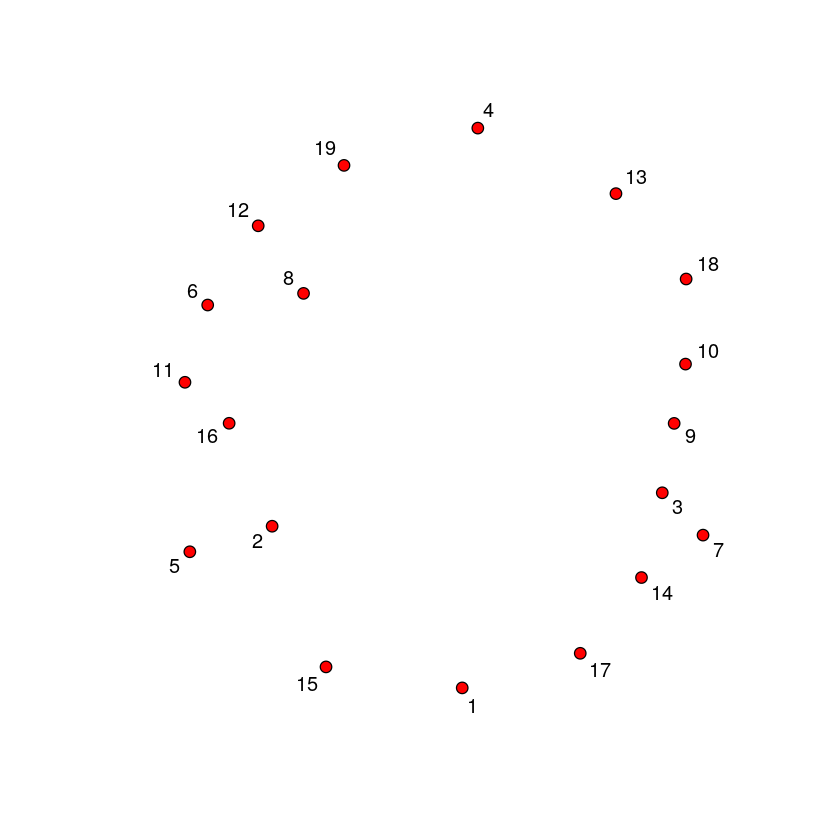

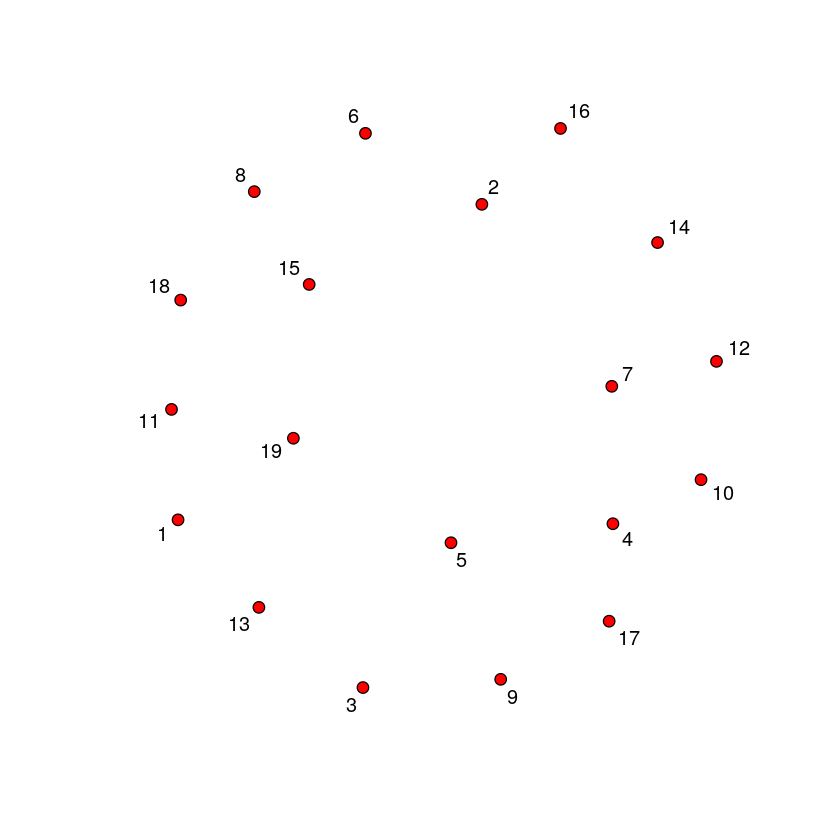

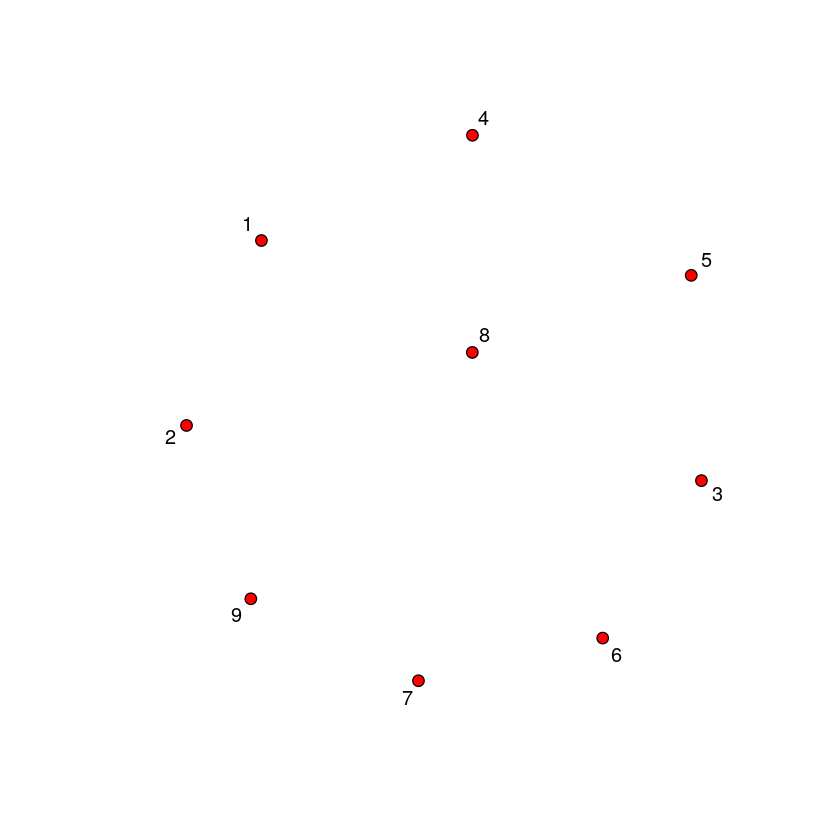

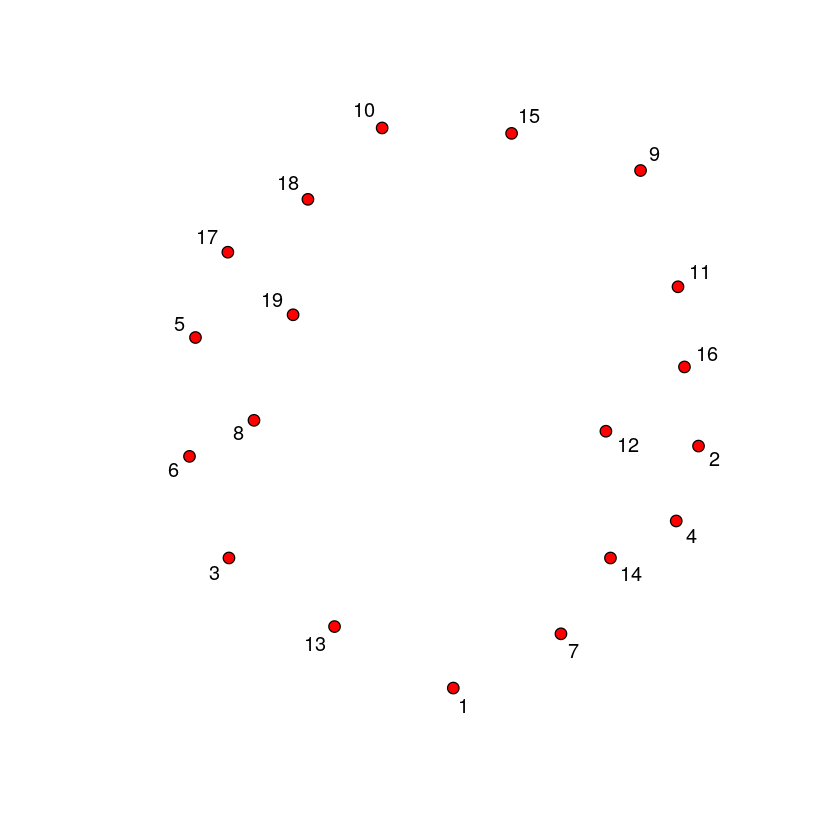

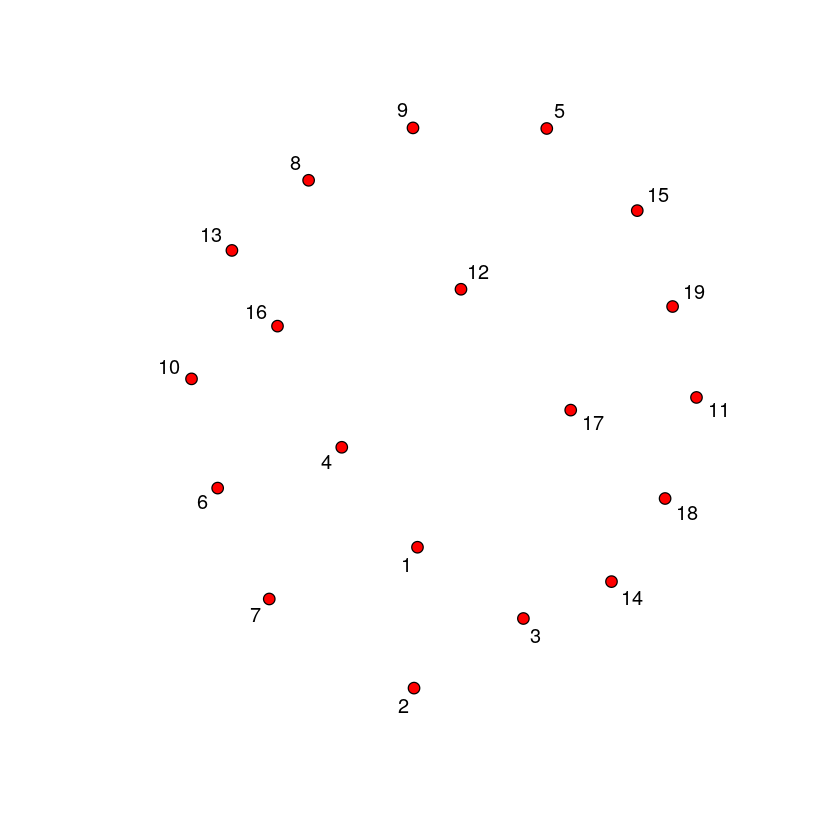

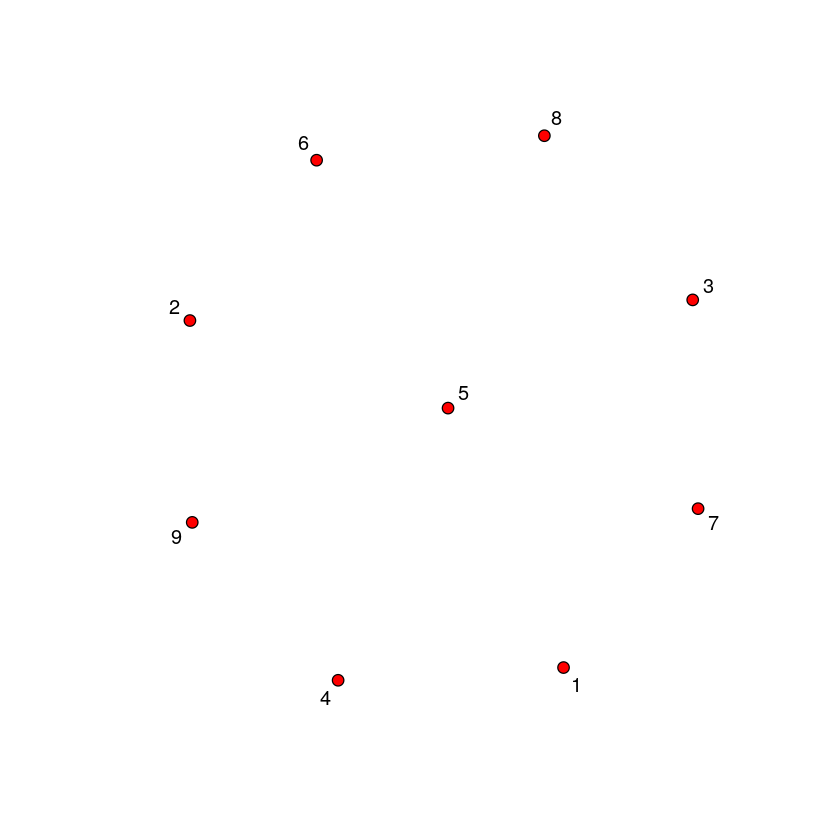

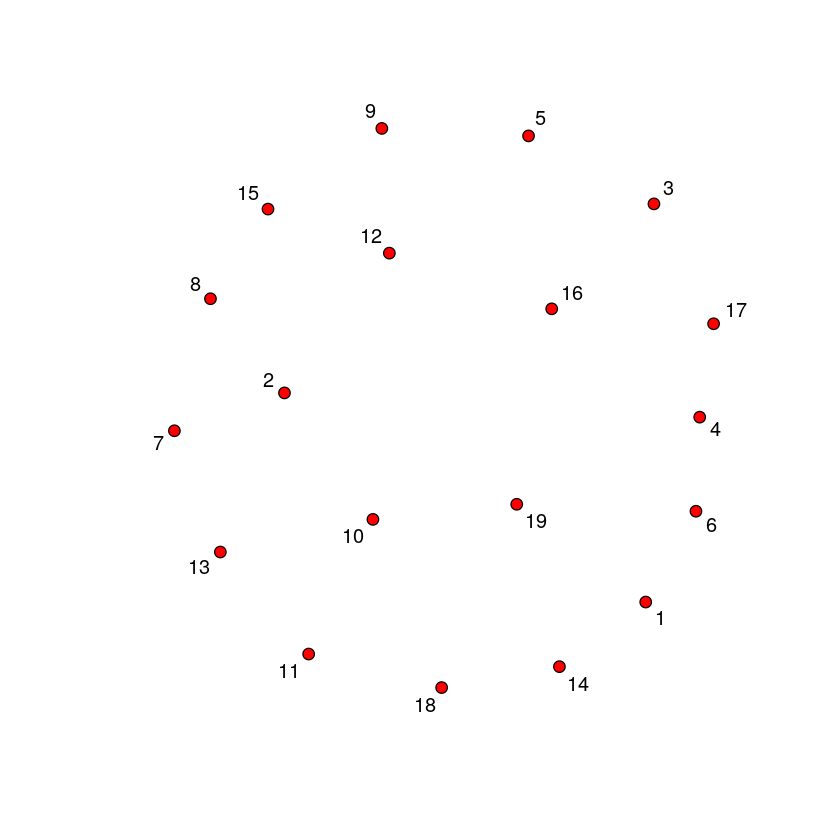

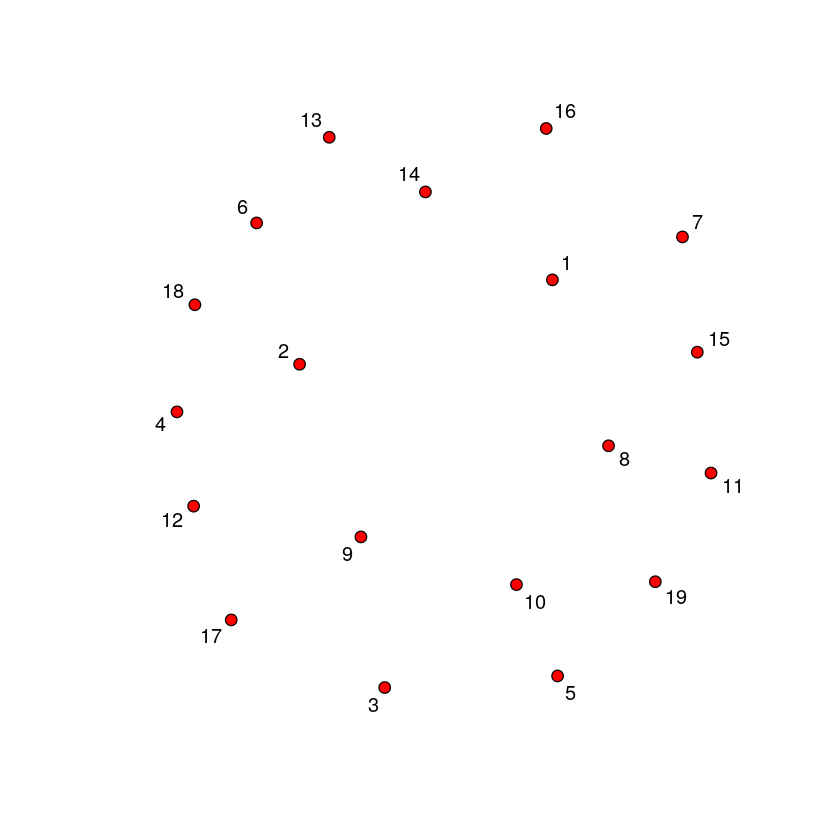

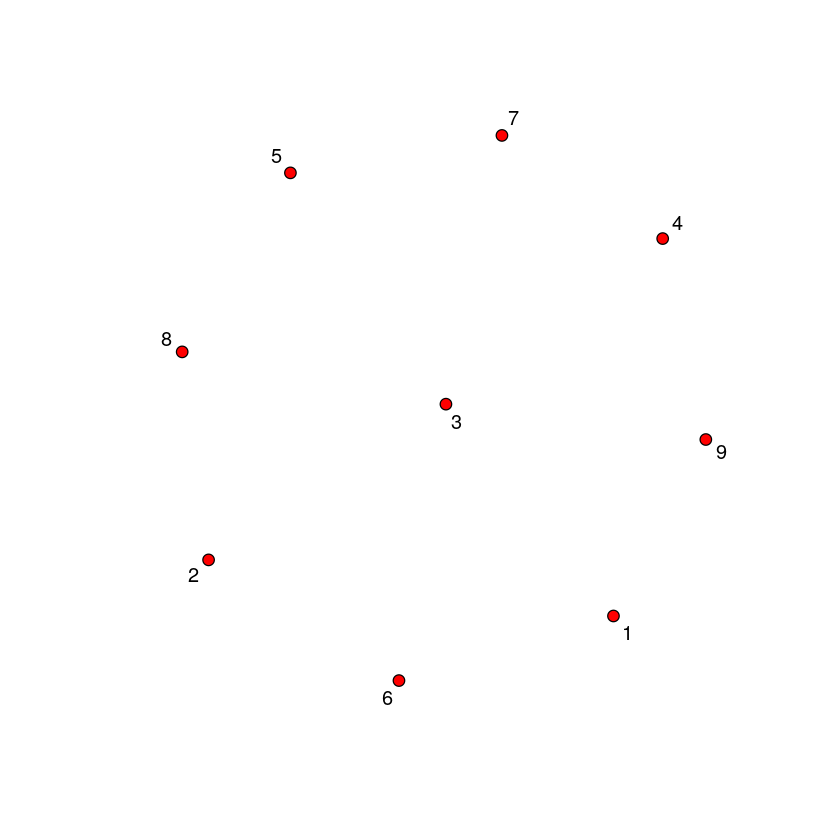

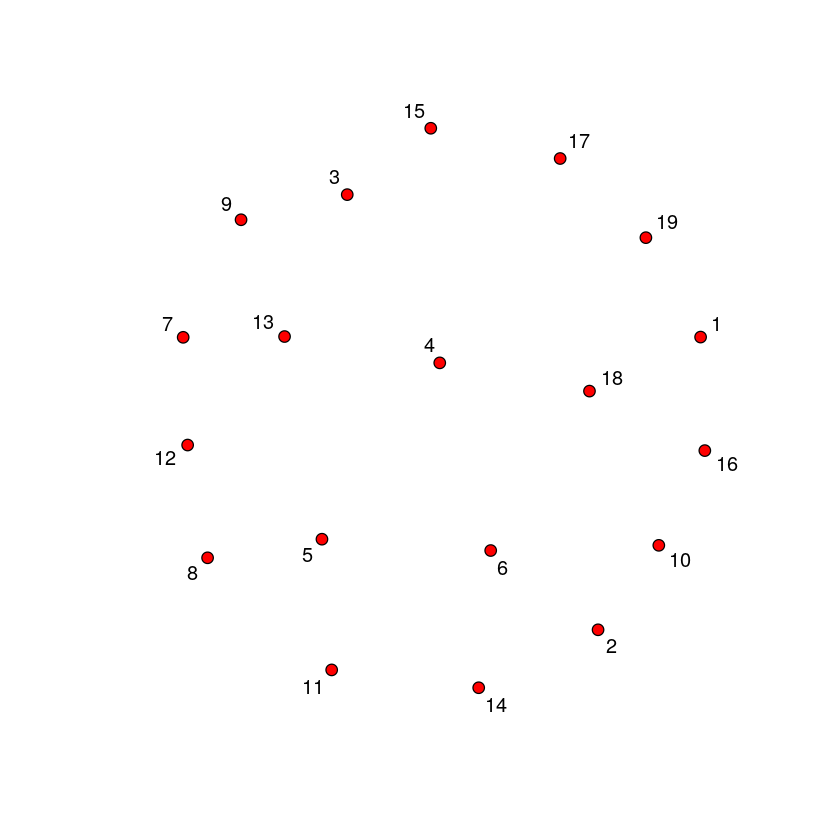

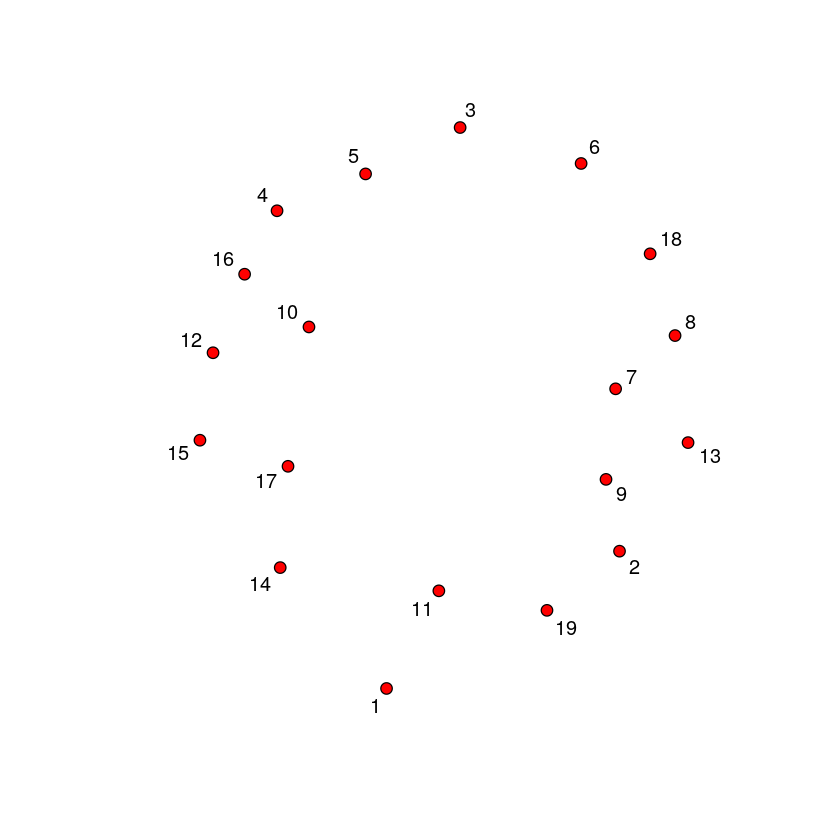

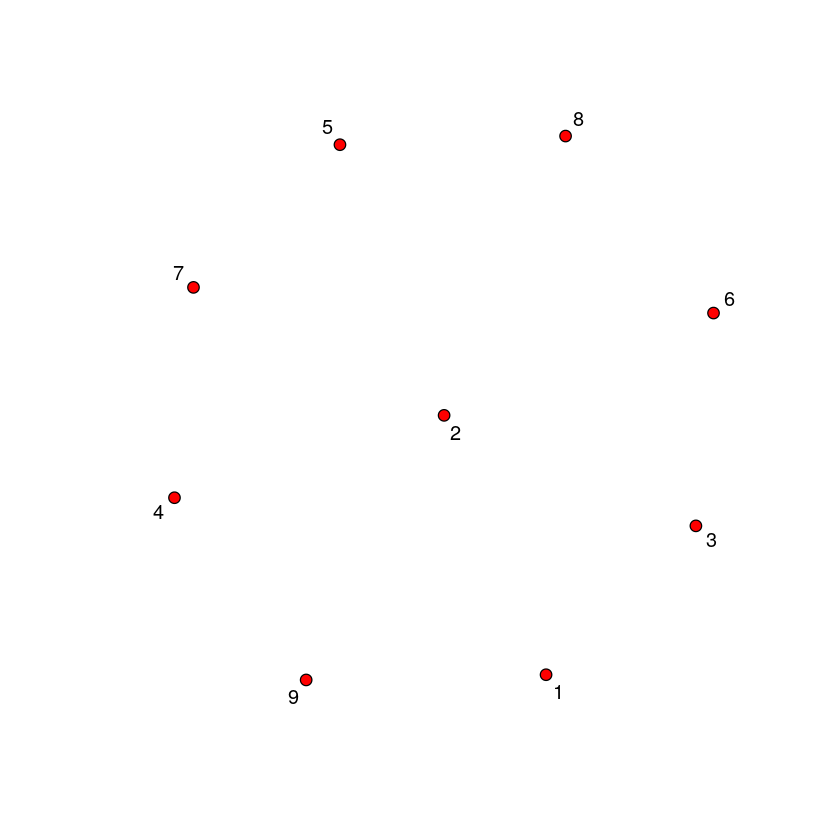

In [115]:
for(i in 1:length(nets)){
    X = nets[[i]]$partial_correlation$estimate
    labs = colnames(nets[[i]]$partial_correlation$estimate)
    GRest <- selectFast(X,)
    g = GRest$EW$G
    colnames(g) = labs
    nets[[i]]$gaussian_graphical_model = g
    g <- network(GRest$EW$G)
    plot(g, jitter=TRUE, usearrows = FALSE, label=1:p,displaylabels=TRUE)
}
